<a href="https://colab.research.google.com/github/freyjagarner/Student-Data-Analysis/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student MOOC Outcome Analysis

## Introduction

In this notebook we will be exploring student demographics and online behavior in online courses.

The first goal of this exploration will be to first find information about our students. Knowing about students helps teachers to improve course content by customizing courses to their audience. For example, if it is found that most of our students only completed high school (or in this dataset A-Levels since this is based on data from the UK region) then teachers can avoid using college level language in order for students to better understand course content.

The second goal of this exploration will be to find which student demographics and behavior are the best predictors of student outcome. This information can also be very useful to teachers. For example if it is found that students who interact on forums are more frequently successful in courses, teachers could perhaps set up forum updates to be sent to students via email to encourage them to interact, or assignments can be created to post and interact on forums potentially improving the odds of student success. 

The final goal of this exploration will be to create a model to predict student success based on the features in the data that we find to be the most significant predictors of student outcome. Such a model could be useful in the way of if applied to all students, teachers could get a notification if a student is predicted to fail at a certain point and the teacher could then reach out to the student to see if they can assist in their studies.

The data for this notebook is the Open University Learning Analytics dataset available [here](https://analyse.kmi.open.ac.uk/open_dataset) and is released under the creative commons license CC-BY 4.0.

The dataset consists of seven files:
* *courses* which provides information of each course which consists of a module, the class offered, and presentation, the time at which the class was offered, and the length of the course.
* *studentInfo* Which contains ID's for individual students, the course the student took, the student demographical information, and the student's final results.
* *studentRegistration* which contains the registration and, if applicable, unregistration dates of students.
* *assessments* which contains the assessment information per module.
* *studentAssessment* which contains the student assessment scores.
* *vle* which contains inforamtion about the virtual learning environment resources.
* *studentVle* which contains information about student interaction with the virtual learning environment.

### Initial Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Capstone')

# import libraries, data and helper functions
from functions import *

## Cleaning

### Courses

---

The courses dataframe has information for all modules and their presentations.

In [223]:
# show head of courses dataframe
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


---

#### Courses Contents

* **code_module**: The code module represents the code name of the course. Modules are identified with three capital letters which run sequentially between AAA and GGG
* **code_presentation**: The presentations are codified by their year and offering semester. B is for February and J is for October. 2013B for example is February of 2013. 
* **mode_presentation_length**: The module presentation length is the length of the course in days.

* First the column names will be changed to be less verbose
    * code_module to module
    * code_presentation to presentation
    * module_presentation_length to course_length

In [224]:
# rename columns
courses_rename = {'code_module':'module', 'code_presentation':'presentation', 'module_presentation_length':'course_length'}
courses = courses.rename(columns=courses_rename)

---

#### Courses Information

**Size**

In [225]:
# get row & column count for courses dataframe
get_size(courses)

,Count
Columns,3
Rows,22


In [226]:
md(f'''
Courses has {len(courses.columns)} columns and {len(courses)} rows
''')


Courses has 3 columns and 22 rows


**Data Types**

In [227]:
# show data types for courses dataframe
get_dtypes(courses)

,Variable,Type
0,module,object
1,presentation,object
2,course_length,int64


`module` and `presentation` are categorical variables and will be converted to `string` so we can later combine them to get the unique courses

In [228]:
# convert objects into datatypes that support pandas NA
courses = courses.convert_dtypes(convert_integer=False)

**Null Values**

In [229]:
# show null values for columns in courses
null_vals(courses)

,Variable,Null Values
0,module,0
1,presentation,0
2,course_length,0


**Duplicate Values**

In [230]:
# show duplicate values in courses if any
get_dupes(courses)

There are no Duplicate Values

**Unique Counts**

In [231]:
# get counts for the unque values in courses columns
count_unique(courses)

,Variable,Count
0,module,7
1,presentation,4
2,course_length,7


In [232]:
# store the number of unique modules
mod_count = courses['module'].nunique()

# store the number of unique presentations
presentation_count = courses['presentation'].nunique()

# store the minimum module length in days
min_mod_count = courses['course_length'].min()

# store the maximum module length in dats
max_mod_count = courses['course_length'].max()

# store the average module length in days
avg_mod_count = round(courses['course_length'].mean(), 1)

md(f'''There are {mod_count} unique modules delivered over {presentation_count} presentations''')

There are 7 unique modules delivered over 4 presentations

**Unique Categorical Values**

In [233]:
# get the unique categorical values in courses
unique_vals(courses)

,Variable,Values
0,module,"[AAA, BBB, CCC, DDD, EEE, FFF, GGG]"
1,presentation,"[2013J, 2014J, 2013B, 2014B]"


Here we can see the modules AAA through GGG and the four presentations they were delivered over

In [234]:
# making a crosstab to map each code module to its presentation
modules_dates = pd.crosstab(index=courses['presentation'], columns=courses['module'])
modules_dates = modules_dates.replace(1, pd.Series(modules_dates.columns, modules_dates.columns))
modules_dates

module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
presentation,,,,,,,
2013B,0,BBB,0,DDD,0,FFF,0
2013J,AAA,BBB,0,DDD,EEE,FFF,GGG
2014B,0,BBB,CCC,DDD,EEE,FFF,GGG
2014J,AAA,BBB,CCC,DDD,EEE,FFF,GGG


Here is a breakdown of each presentation and what modules were offered during that time

**Numerical Values**

In [235]:
# show statistical breakdown of numerical values in courses
courses.describe().round(1)

,course_length
count,22.0
mean,255.5
std,13.7
min,234.0
25%,241.0
50%,261.5
75%,268.0
max,269.0


In [236]:
md(f"""
* Modules range from {min_mod_count} to {max_mod_count} days in length.
* The average module is {avg_mod_count} days.
""")


* Modules range from 234 to 269 days in length.
* The average module is 255.5 days.


### Student Information

---

The student info file contains details about students including the module they took, the presentation they took the module during, demographic information and the final result of their studies.

In [237]:
# looking at the stud_info dataframe
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


#### Student Info Contents

* **code_module**: The code module represents the course the student is taking.
* **code_presentation**: The code presentations are the year and semester the student is taking the course.
* **id_student**: The student ID is a unique identifier for each student
* **gender**: The gender represents the binary gender of a student 'M' for students who identify as male and 'F' for students who identify as female.
* **region**: Region represents the location of the student when they took the module. All regions are in the UK, Scotland, Ireland or Wales.
* **highest_education**: Highest education is representative of a students highest level of formal academic achievement.
    - Education levels in order from least to most formal education: 
        - No formal quals (qualifications)
        - Lower than A Level which is nearly but not quite analagous to under high school level
        - A Level or equivalent which is again nearly analagous to high school level, but more like college ready
        - HE Qualification which stands for higher education qualification
        - Post Graduate Qualification
* **imd_band**: The imd_band represents the Indices of multiple deprivation (IMD) score which is a commonly used method in the UK to measure poverty or deprivation in an area. The lower the score, the more 'deprived' the area is.
* **age_band**: There are only three bins for age; _0-35_, _35-55_ and _55<=_
* **num_of_prev_attempts**: The number of times the student has attempted the course previously.
* **studied_credits**: The number of credits for the module the student is taking.
* **disability**: Disability status is represented by a binary 'Y', yes a student does identify as having a disability and 'N', no a student does not identify as having a disability.
* **final_results**: * The final result is the students overall result in the class.
    - Possible Results include:
         - _Pass_: The student passed the course
         - _Fail_: The student did not pass the course
         - _Withdraw_: The student withdrew before the course term ended
         - _Distinction_: The student passed the class with distinction

#### Student Registration

---

The information that the student registration file adds includes the dates that students registered and, if applicable, unregistered from the module.

In [238]:
# looking at the student_registration dataframe
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


#### Student Registration Contents

* **code_module**: The code module represents the course which the sutdent registered for.
* **code_presentation**: The code presentation represents the time of year the course which the student registered for began.
* **id_student**: The student ID is the unique identifier for each student.
* **date_registration**: The registration date is the date that the student registered for the module relative to the start of the module. A negative value indicates that many days before the module began.
* **date_unregistration**: The unregistration date is the date that the student unregistered from the course module in relation to the start date of the course, if applicable.

```{note}
* The student registration dataframe matches 1:1 with the student info dataframe only adding the date the student registered and the date in which they unregistered, and so we will merge these two dataframes.
* The dataframe columns can then be reordered to keep relevent data together. 
```

In [239]:
# outer join and merge student info with student registration
stud_info = student_info.merge(student_registration, how='outer', on=['code_module', 'code_presentation', 'id_student'], indicator=False)

# reordering the stud_info dataframe to keep country, module and student data together
stud_info = stud_info[['code_module', 'code_presentation', 'id_student', 'region', 'imd_band', 'age_band', 'gender', 'highest_education', 'disability', 'num_of_prev_attempts', 'studied_credits', 'final_result', 'date_registration', 'date_unregistration']]

* Column names will be changed to be less verbose
    * code_module to module
    * code_presentation to presentation
    * highest_education to education
    * imd_band to imd
    * age_band to age
    * num_of_prev_attempts to attempts
    * studied_credits to credits
    * final result to result
    
* Column values will be changed to be less verbose:
    * education
        - `HE Qualification` to `HE`
        - `A Level or Equivalent` to `A Level`
        - `Lower than A Level` to `Under A Level`
        - `Post Graduate Qualification` to `Post Grad`
        - `No Formal quals` to `No Formal`
    * region
        - Region will be removed from the end of each region name

In [240]:
# rename columns to be easier to see/work with
stud_info_rename = {'code_module':'module', 'code_presentation':'presentation', 'final_result':'result', 'studied_credits':'credits', 'age_band':'age', 'num_of_prev_attempts':'attempts', 'highest_education':'education', 'imd_band':'imd'}
stud_info = stud_info.rename(columns=stud_info_rename)

# rename column values to be easier to see/work with
stud_info = stud_info.replace({'region':{'East Anglian Region':'East Anglian', 'North Western Region':'North Western', 'South East Region':'South East', 'West Midlands Region':'West Midlands', 'North Region':'North',
 'South Region':'South', 'South West Region':'South West', 'East Midlands Region':'East Midlands',
 'Yorkshire Region':'Yorkshire', 'London Region':'London'}, 'education':{'HE Qualification':'HE', 'A Level or Equivalent':'A Level', 'Post Graduate Qualification':'Post Grad', 'No Formal quals':'No Formal', 'Lower Than A Level':'Under A Level'}})

#### Student Info Information

**Size**

In [241]:
get_size(stud_info)

,Count
Columns,14
Rows,32593


In [242]:
md(f'''
`stud_info` has {len(stud_info.columns)} columns and {'{:,}'.format(len(stud_info))} rows representing our students and their information.
''')


`stud_info` has 14 columns and 32,593 rows representing our students and their information.


**Data Types**

In [243]:
# show student info data types
get_dtypes(stud_info)

,Variable,Type
0,module,object
1,presentation,object
2,id_student,int64
3,region,object
4,imd,object
5,age,object
6,gender,object
7,education,object
8,disability,object
9,attempts,int64


* `id_student`, `module`, `region`, `imd`, `age`, `gender`, `education`, `result` and `presentation` will be converted to `string`

In [244]:
# changing id_student to the category data type
stud_info = stud_info.astype({'id_student':str})
stud_info = stud_info.convert_dtypes()

**Null Values**

In [245]:
null_vals(stud_info)

,Variable,Null Values
0,module,0
1,presentation,0
2,id_student,0
3,region,0
4,imd,1111
5,age,0
6,gender,0
7,education,0
8,disability,0
9,attempts,0


In [246]:
# store sum of imd null values
imd_null = stud_info['imd'].isnull().sum()

# store the sum of null values of date_registration
null_registration = student_registration['date_registration'].isnull().sum()

# store the sum of null values of date_unregistration
null_unregistration = student_registration['date_unregistration'].isnull().sum()

# locate where stud_info has a result of withdrawn and a date_unregistration of NA
withdrawn_na = stud_info.loc[(stud_info['result'] == 'Withdrawn') & (stud_info['date_unregistration'].isna())]


md(f'''
* The `imd` variable has {"{:,}".format(imd_null)} null values. For these, we will find the most common imd band for each region and assert that as the value.
* We have {null_registration} null values for date_registration, and no mention of this in the dataset documentation, so we will treat this as missing data.
We will fill these missing dates with the average registration date.
* There are {"{:,}".format(null_unregistration)} null values for `date_unregistration` which represent the students that did not withdraw from the course.
    * Not every withdrawn student has a date that they unregistered. There are {len(withdrawn_na)} entries of students with a `Withdrawn` result but a `date_unregstration` of `<NA>`''')


* The `imd` variable has 1,111 null values. For these, we will find the most common imd band for each region and assert that as the value.
* We have 45 null values for date_registration, and no mention of this in the dataset documentation, so we will treat this as missing data.
We will fill these missing dates with the average registration date.
* There are 22,521 null values for `date_unregistration` which represent the students that did not withdraw from the course.
    * Not every withdrawn student has a date that they unregistered. There are 93 entries of students with a `Withdrawn` result but a `date_unregstration` of `<NA>`

In [247]:
for index, row in stud_info[stud_info['date_registration'].isna()].iterrows():
    # set the imd at the index of the sub dataframe to the key of the region in the dict in the main dataframe
    stud_info.at[index, 'date_registration'] = int(stud_info['date_registration'].mean())

In [248]:
# find the unique values in regions 
regions = stud_info['region'].values.unique()

# initiate a dictionary for {region:imd}
common_imds = {}

# iterate through regions values
for i in regions:
    # locate the imds for each region in stud_info
    region_imds = stud_info.loc[stud_info['region'] == i, 'imd']
    # get the value_counts for the regions imds and add the highest count to a dict keyed by region
    common_imds[i] = region_imds.value_counts().reset_index()['index'][0]

# iterate through a sub dataframe of stud_info where imd is NA
for index, row in stud_info[stud_info['imd'].isna()].iterrows():
    # set the imd at the index of the sub dataframe to the key of the region in the dict in the main dataframe
    stud_info.at[index, 'imd'] = common_imds[row['region']]

**Duplicate Values**

In [249]:
# show duplicate values in student info if any
get_dupes(stud_info)

There are no Duplicate Values

**Unique Counts**

In [250]:
# Get number of unique values per variable in student info
count_unique(stud_info)

,Variable,Count
0,module,7
1,presentation,4
2,id_student,28785
3,region,13
4,imd,10
5,age,3
6,gender,2
7,education,5
8,disability,2
9,attempts,7


In [251]:
# store count of total student ids
total_students = stud_info['id_student'].count()

# store count of unique student ids
unique_students = stud_info['id_student'].nunique()

# retrieve all records from students in stud_info whose id is duplicated
dupe_students = stud_info[stud_info.duplicated(subset=['id_student'], keep=False)]

# convert the datatypes back in dupe_students
dupe_students = dupe_students.astype({'id_student':'category'})
dupe_students = dupe_students.convert_dtypes()

# subset those who took multiple modules in the same presentation by finding duplicate id_students and presentations
mult_mods = dupe_students[dupe_students.duplicated(subset=['id_student', 'presentation'], keep=False)]

# subset those who took multiple attempts by finding duplicate id_students and modules
mult_attempt = dupe_students[dupe_students.duplicated(subset=['module','id_student'], keep=False)]

# merge students with multiple attempts and who took multiple modules to find the students we have values for
merged_attempt_mods = mult_attempt.merge(mult_mods, how='outer', on=[i for i in mult_attempt.columns])

# find students that are not in mult_mods or mult_attempt but still duplicated
mult_mods_pres = pd.concat([merged_attempt_mods, dupe_students]).drop_duplicates(keep=False)

# append the multiple module/presentation students to mult_mods
mult_mods = mult_mods.append(mult_mods_pres)

md(f'''
* There are {"{:,}".format(total_students)} entries for students but only {"{:,}".format(unique_students)} unique student IDs.
* {"{:,}".format(mult_mods['id_student'].nunique())} student IDs appear multiple times due to students taking multiple modules
* {"{:,}".format(mult_attempt['id_student'].nunique())} student IDs appear multiple times due to students attempting the same module more than once.
''')


* There are 32,593 entries for students but only 28,785 unique student IDs.
* 2,479 student IDs appear multiple times due to students taking multiple modules
* 1,259 student IDs appear multiple times due to students attempting the same module more than once.


**Unique Categorical Values**

In [252]:
unique_vals(stud_info)

,Variable,Values
0,module,"[AAA, BBB, CCC, DDD, EEE, FFF, GGG]"
1,presentation,"[2013J, 2014J, 2013B, 2014B]"
2,region,"[East Anglian, Scotland, North Western, South ..."
3,imd,"[90-100%, 20-30%, 30-40%, 50-60%, 80-90%, 70-8..."
4,age,"[55<=, 35-55, 0-35]"
5,gender,"[M, F]"
6,education,"[HE, A Level, Under A Level, Post Grad, No For..."
7,disability,"[N, Y]"
8,result,"[Pass, Withdrawn, Fail, Distinction]"


In imd_band the % sign is missing in 10-20. We will add that for consistency and clarity

In [253]:
# changing all 10-20 values in stud_info imd_band to 10-20%
stud_info.loc[stud_info['imd'] == '10-20', 'imd'] = '10-20%'

**Numerical Values**

In [254]:
# show statistical breakdown of numerical values in student info
stud_info.describe(include='int64').round(1)

,attempts,credits,date_registration,date_unregistration
count,32593.0,32593.0,32593.0,10072.0
mean,0.2,79.8,-69.4,49.8
std,0.5,41.1,49.2,82.5
min,0.0,30.0,-322.0,-365.0
25%,0.0,60.0,-100.0,-2.0
50%,0.0,60.0,-57.0,27.0
75%,0.0,120.0,-29.0,109.0
max,6.0,655.0,167.0,444.0


In [255]:
# store the highest number of module previous attempts by students
max_attempts = stud_info['attempts'].max()

# store the highest number of credits a student took
max_credits = stud_info['credits'].max()

# store the lowest amount of credits a student took
min_credits = stud_info['credits'].min()

# store the count of students with an unregistration date
unreg_total = student_registration['date_unregistration'].count()

# store the smallest value for unregistration date
unreg_min = student_registration['date_unregistration'].min()

md(f'''
* Most students do not have a previous attempt, but there is a high of {max_attempts} attempts.
    * We can only have data for up to two of the students attempts since we only have two years worth of data.
* The maximum amount of credits a student took during the module was {max_credits}
    * This over twenty times the minimum of {min_credits} credits.
* It is unknown how these courses were weighted, but this amount of credits at the same time may have influenced student success
* There are {"{:,}".format(unreg_total)} values for of date_unregistration which represents the number of students who withdrew from the course.
* The earliest date_unregistration date is {unreg_min} days before the course began, which means this student did not make it to the first day. 
''')


* Most students do not have a previous attempt, but there is a high of 6 attempts.
    * We can only have data for up to two of the students attempts since we only have two years worth of data.
* The maximum amount of credits a student took during the module was 655
    * This over twenty times the minimum of 30 credits.
* It is unknown how these courses were weighted, but this amount of credits at the same time may have influenced student success
* There are 10,072 values for of date_unregistration which represents the number of students who withdrew from the course.
* The earliest date_unregistration date is -365.0 days before the course began, which means this student did not make it to the first day. 


**Early Withdrawals**

In [256]:
# find students in stud_info with an unregistration date before the course started and display them
early_withdraws = stud_info.loc[stud_info['date_unregistration'] <= 0]
early_withdraws.head()

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration
125,AAA,2013J,292923,South East,90-100%,35-55,F,A Level,N,0,180,Withdrawn,-162,-121
136,AAA,2013J,305539,Wales,80-90%,0-35,F,Under A Level,N,0,120,Withdrawn,-54,-3
198,AAA,2013J,405961,Scotland,90-100%,0-35,M,A Level,Y,0,240,Withdrawn,-170,-100
256,AAA,2013J,1763015,Scotland,10-20%,35-55,F,A Level,N,0,60,Withdrawn,-58,-2
298,AAA,2013J,2318055,Wales,90-100%,35-55,M,A Level,N,0,60,Withdrawn,-56,-19


In [257]:
md(f'''
Here we can see the {"{:,}".format(len(early_withdraws))} students with a withdrawal date before the first day,
let's look at their results:
''')


Here we can see the 3,097 students with a withdrawal date before the first day,
let's look at their results:


In [258]:
# find possible result values in early withdraw students
dataframe(early_withdraws['result'].value_counts())

,result
Withdrawn,3089
Fail,8


While the bulk of these students Withdrew, it seems some managed to fail before the first day. Let's look at these students

In [259]:
# find students in early_withdraw with a fail result
early_withdraws[early_withdraws['result'] == 'Fail']

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration
2777,BBB,2013J,362907,South West,20-30%,35-55,F,Under A Level,N,2,60,Fail,-37,0
2786,BBB,2013J,365288,South,70-80%,0-35,F,A Level,N,0,60,Fail,-75,0
14625,DDD,2013J,315082,West Midlands,50-60%,0-35,M,A Level,N,0,60,Fail,-73,0
14768,DDD,2013J,403052,Yorkshire,20-30%,0-35,F,HE,N,0,150,Fail,-22,0
15577,DDD,2013J,582954,London,10-20%,0-35,M,Under A Level,N,0,120,Fail,-81,-7
24057,FFF,2013J,234004,Yorkshire,50-60%,0-35,M,A Level,N,0,60,Fail,-33,0
24537,FFF,2013J,523777,North,0-10%,35-55,M,A Level,N,1,60,Fail,-60,0
25685,FFF,2013J,601640,London,20-30%,0-35,M,HE,N,0,90,Fail,-58,-4


In [260]:
md('''
So despite the fact that all of these students did unregister, they were for some reason marked as Fails. Let's see how many students have an
unregistration date but are not marked as withdrawn
''')


So despite the fact that all of these students did unregister, they were for some reason marked as Fails. Let's see how many students have an
unregistration date but are not marked as withdrawn


In [261]:
# Find students who withdrew but are not marked as withdrawn
stud_info[(stud_info['result'] != 'Withdrawn') & (~stud_info['date_unregistration'].isna())]

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration
2777,BBB,2013J,362907,South West,20-30%,35-55,F,Under A Level,N,2,60,Fail,-37,0
2786,BBB,2013J,365288,South,70-80%,0-35,F,A Level,N,0,60,Fail,-75,0
3340,BBB,2013J,554243,South West,60-70%,0-35,F,Under A Level,N,0,60,Fail,-35,166
14625,DDD,2013J,315082,West Midlands,50-60%,0-35,M,A Level,N,0,60,Fail,-73,0
14768,DDD,2013J,403052,Yorkshire,20-30%,0-35,F,HE,N,0,150,Fail,-22,0
15577,DDD,2013J,582954,London,10-20%,0-35,M,Under A Level,N,0,120,Fail,-81,-7
24057,FFF,2013J,234004,Yorkshire,50-60%,0-35,M,A Level,N,0,60,Fail,-33,0
24537,FFF,2013J,523777,North,0-10%,35-55,M,A Level,N,1,60,Fail,-60,0
25685,FFF,2013J,601640,London,20-30%,0-35,M,HE,N,0,90,Fail,-58,-4


We can see there are a few students who are improperly marked as failing when they withdrew. Let's fix these entries

In [262]:
# change the values of result Fail where result should be Withdrawn
stud_info.loc[(stud_info['result'] != 'Withdrawn') & (~stud_info['date_unregistration'].isna()), 'result'] = 'Withdrawn'

We will now drop any students with a registration date before 0 (day 1) of the course, because we are only interested in students who at least began the courses.

In [263]:
# keep only student info entries where the date of unregistration before day one or did not unregister
stud_info = stud_info[(stud_info['date_unregistration'] > 0) | (stud_info['date_unregistration'].isna())]

Let's see if there are any students where the opposite case is true - where they are marked as having withdrawn but have no unregistration date.

In [264]:
# find students who have a result of withdrawn with no unregistration date
stud_info.loc[(stud_info['result'] == 'Withdrawn') & (stud_info['date_unregistration'].isna())]

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration
6315,BBB,2014B,2512349,Yorkshire,40-50%,35-55,F,Under A Level,N,0,60,Withdrawn,-17,<NA>
6484,BBB,2014J,271047,South West,90-100%,0-35,F,Under A Level,N,0,60,Withdrawn,-25,<NA>
6601,BBB,2014J,417978,Wales,80-90%,35-55,F,HE,N,0,60,Withdrawn,-24,<NA>
7247,BBB,2014J,636660,North Western,0-10%,0-35,F,Under A Level,N,0,60,Withdrawn,-113,<NA>
7410,BBB,2014J,647876,East Anglian,80-90%,0-35,F,Under A Level,N,0,120,Withdrawn,-162,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29978,FFF,2014J,2398260,London,10-20%,35-55,M,Under A Level,N,0,180,Withdrawn,-38,<NA>
30032,FFF,2014J,2622634,Ireland,10-20%,35-55,M,A Level,N,1,60,Withdrawn,-29,<NA>
30562,GGG,2013J,590248,Yorkshire,30-40%,0-35,F,Under A Level,N,0,30,Withdrawn,-16,<NA>
32149,GGG,2014J,646891,South,10-20%,35-55,F,Under A Level,N,0,60,Withdrawn,2,<NA>


In [265]:
# get a count of student id's with a withdrawn result
withdrawn_students = int(stud_info.loc[stud_info['result'] == 'Withdrawn']['id_student'].count())

# get a count of students who withdrew but have no unregistration date
no_unreg_withdrawn = stud_info.loc[(stud_info['result'] == 'Withdrawn') & (stud_info['date_unregistration'].isna())]['id_student'].count()

# find the percentage of students who withdrew and have no unreg date to the overall withdrawn students
perc_missing_unreg = percentage(no_unreg_withdrawn, withdrawn_students)

md(f'''
Above is a table of students who withdrew but have no unregistration date. 

{no_unreg_withdrawn} out of {withdrawn_students} students who withdrew or {perc_missing_unreg}% of withdrawn 
students do not have an unregistration date like they should. This should not affect our analysis and will
be left, but the incompleteness of this data set is of note.
''')


Above is a table of students who withdrew but have no unregistration date. 

93 out of 7068 students who withdrew or 1.32% of withdrawn 
students do not have an unregistration date like they should. This should not affect our analysis and will
be left, but the incompleteness of this data set is of note.


**Late Unregistration**

In [266]:
# finds the longest module length in courses 
longest_course = courses['course_length'].max()

# find the maximum unregistration date
longest_unreg = int(student_registration['date_unregistration'].max())

md(f'''* The longest course from course_length length in the courses dataframe was {longest_course} days, yet we see here the 
latest unregistration date is {longest_unreg} days, which is longer than any course went on.
''')

* The longest course from course_length length in the courses dataframe was 269 days, yet we see here the 
latest unregistration date is 444 days, which is longer than any course went on.


All Students with an unregistration point after 269 days:

In [267]:
# finding students whose courses went on for longer than the maximum course length
student_registration.loc[student_registration['date_unregistration'] > 269]

,code_module,code_presentation,id_student,date_registration,date_unregistration
25249,FFF,2013J,586851,-22.0,444.0


* It seems to be just this one student is an outlier, but should not affect our overall analysis so we will leave this intact
* The registration date is unlikely to provide any more interesting information to us and will be dropped

### Assessments
---

The assessments dataframe contains information about the unique assessments in each code module and presentation.

In [268]:
# show assessments dataframe
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


---

#### Assessments Contents

* **code_module**: The code module represents the code name of the course the assessment was held for.
* **code_presentation**: The presentation represents the presentation which the test was held for.
* **id_assessment**: The assessment ID is the unique identifier for each assessment.
* **assessment_type**: The assessment type represents the kind of assessment it was.
    - There are three assessment types:
        * TMA: Tutor Marked Assessment
        * CMA: Computer Marked Assessment
        * Exam: The Final Exam
* **date**: The date is how many days from the start of the course the assessment took place
* **weight**: The weight is the weighted value of the assessment. Exams should have a weight of 100 which the rest of the assessments should add to 100 in total.

* column names will be changed to be less verbose
    * code_module to module
    * code_presentation to presentation

In [269]:
# make a dictionary of columns mapping to their new name
assessments_rename = {'code_module':'module', 'code_presentation':'presentation'}

# rename columns in assessments based on dictionary
assessments = assessments.rename(columns=assessments_rename)

---

#### Assessments Information

**Size**

In [270]:
# function to get a dataframe of rows and columns
get_size(assessments)

,Count
Columns,6
Rows,206


In [271]:
md(f'''
Assessments has {len(assessments.columns)} features describing {len(assessments)} exam records.
''')


Assessments has 6 features describing 206 exam records.


**Data Types**

In [272]:
# function to get a dataframe of data types
get_dtypes(assessments)

,Variable,Type
0,module,object
1,presentation,object
2,id_assessment,int64
3,assessment_type,object
4,date,float64
5,weight,float64


* `module`, `presentation`,`assessment_type` and `id_student` will be converted to string

In [273]:
# converting id_assessment to string
assessments= assessments.astype({'id_assessment':str})

# all other data types to those which support pandas <NA>
assessments = assessments.convert_dtypes(convert_integer=False)

**Null Values**

In [274]:
# function to return dataframe of nulls in columns
null_vals(assessments)

,Variable,Null Values
0,module,0
1,presentation,0
2,id_assessment,0
3,assessment_type,0
4,date,11
5,weight,0


In [275]:
md(f'''
* We have {assessments['date'].isnull().sum()} null data points for assessment date. 
* The documentation of this dataset states that if the exam date is missing then it is as the end of the last presentation week. 
* We can find this information in the courses dataframe, and add them in to get rid of the NaNs.
''')


* We have 11 null data points for assessment date. 
* The documentation of this dataset states that if the exam date is missing then it is as the end of the last presentation week. 
* We can find this information in the courses dataframe, and add them in to get rid of the NaNs.


In [276]:
# iterate through assessments entries where date is NA
for index, row in assessments[assessments['date'].isna()].iterrows():
    # change assessments date at current index to the course_length found in courses by locating the matching module/presentation
    assessments.at[index, 'date'] = courses.loc[(courses['module'] == row['module']) & (courses['presentation'] == row['presentation']), 'course_length']

# give a dataframe of null values to ensure there are now none
dataframe(assessments.isnull().sum(), columns=['Null Values'])

,Null Values
module,0
presentation,0
id_assessment,0
assessment_type,0
date,0
weight,0


**Unique Counts**

In [277]:
# function to get unique value counts
count_unique(assessments)

,Variable,Count
0,module,7
1,presentation,4
2,id_assessment,206
3,assessment_type,3
4,date,78
5,weight,24


In [278]:
md(f'''
There are {assessments['id_assessment'].nunique()} unique assessment ID's
''')


There are 206 unique assessment ID's


**Unique Categorical Values**

In [279]:
# function to get unique categorical values in columns
unique_vals(assessments)

,Variable,Values
0,module,"[AAA, BBB, CCC, DDD, EEE, FFF, GGG]"
1,presentation,"[2013J, 2014J, 2013B, 2014B]"
2,id_assessment,"[1752, 1753, 1754, 1755, 1756, 1757, 1758, 175..."
3,assessment_type,"[TMA, Exam, CMA]"


Everything here is as we would expect in the data's description

In [280]:
# get the value counts for each type of exam
dataframe(assessments['assessment_type'].value_counts())

,assessment_type
TMA,106
CMA,76
Exam,24


In [281]:
# store counts for each type of exam in assessments
TMA_count = assessments['assessment_type'].value_counts()[0]
CMA_count = assessments['assessment_type'].value_counts()[1]
exam_count = assessments['assessment_type'].value_counts()[2]

md(f'''
There are {TMA_count} Tutor Marked Assessements, {CMA_count} Computer Marked Assessments and {exam_count} Final Exams in our data.
''')


There are 106 Tutor Marked Assessements, 76 Computer Marked Assessments and 24 Final Exams in our data.


Our data source tells us that final exams are weighted 100 and the weights of the rest of the exams in a module should amount to 100. So each module should have a total weight of 200.

In [282]:
# create a pivot table grouped by presentation and then module then the total exam weight
pd.pivot_table(assessments, index=['presentation', 'module'], values='weight', aggfunc=np.sum)

weight
presentation module        
2013B        BBB      200.0
             DDD      200.0
             FFF      200.0
2013J        AAA      200.0
             BBB      200.0
             DDD      200.0
             EEE      200.0
             FFF      200.0
             GGG      100.0
2014B        BBB      200.0
             CCC      300.0
             DDD      200.0
             EEE      200.0
             FFF      200.0
             GGG      100.0
2014J        AAA      200.0
             BBB      200.0
             CCC      300.0
             DDD      200.0
             EEE      200.0
             FFF      200.0
             GGG      100.0

This pivot table shows the module presentation, the module and the total of the weights of the exams in the module.
Because the final exam is weighted 100 and the other exams should form another 100 we should have 200 points in each module. We see here that CCC modules 300 in total weight and GGG modules have 100 in total weight.

In [283]:
# locate CCC and GGG exams in assessments
ccc_ggg_weights = assessments.loc[(assessments['module'] == 'CCC') | (assessments['module'] == 'GGG')]

# reorder columns for clarity & display dataframe
ccc_ggg_weights = ccc_ggg_weights[['module', 'id_assessment', 'assessment_type', 'weight']]
ccc_ggg_weights

,module,id_assessment,assessment_type,weight
54,CCC,24286,CMA,2.0
55,CCC,24287,CMA,7.0
56,CCC,24288,CMA,8.0
57,CCC,24289,CMA,8.0
58,CCC,24282,TMA,9.0
59,CCC,24283,TMA,22.0
60,CCC,24284,TMA,22.0
61,CCC,24285,TMA,22.0
62,CCC,24290,Exam,100.0
63,CCC,40087,Exam,100.0


We can see here that CCC Modules had two final exams, and the GGG module's full course weight consisted only of a final exam. 

**Duplicate Values:**

In [284]:
# function to output a dataframe of duplicate values
get_dupes(assessments)

There are no Duplicate Values

**Numerical Values**

In [285]:
# show statistical information for numerical values
assessments.describe().round(2)

,date,weight
count,206.00,206.00
mean,150.97,20.87
std,78.16,30.38
min,12.00,0.00
25%,81.25,0.00
50%,159.00,12.50
75%,227.00,24.25
max,269.00,100.00


In [286]:
# find the average weight of assessments
mean_weight = round(assessments['weight'].mean(), 2)

md(f'''
The average test is weighted at {mean_weight}, which makes sense as there is normally 5 tests adding to 100 and then a final which likely brings up that mean.
''')


The average test is weighted at 20.87, which makes sense as there is normally 5 tests adding to 100 and then a final which likely brings up that mean.


### Student Assessment

---

The Student Assessments dataframe contains information about each student and the assessments they took during the module

In [287]:
# show first 5 student_assessment entries
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


---

#### Student Assessment Contents

* **id_assessment**: The assessment ID is the unique identifier for the assessment the student took.
* **id_student**: The student ID is the unique identifier for the student who took the assessment.
* **date_submitted**: The date submitted is the date the student submitted the exam relevant to the start date of the module.
* **is_banked**: Whether the score for the assessment is banked indicates wheter the assessment result was transferred from a previous presentation.
    - is_banked has no relevant information to our analysis and can be removed
* **score**: The score the student received for the assessment. 40 or above is considered a passing score.

In [288]:
# drop is_banked from stud_assessment
student_assessment = student_assessment.drop(columns='is_banked')

---

#### Student Assessment Information

**Size**

In [289]:
# get the size of student_assessment
get_size(student_assessment)

,Count
Columns,4
Rows,173912


In [290]:
# store the size of student_assessment's columns
sa_cols = len(student_assessment.columns)

# store the size of student_assessment's rows
sa_rows = len(student_assessment)

md(f'''
Student Assessment has {sa_cols} columns and {"{:,}".format(sa_rows)} rows, which is how many exams we have data for.
''')


Student Assessment has 4 columns and 173,912 rows, which is how many exams we have data for.


**Data Types**

In [291]:
# get student_assessment column datatypes
get_dtypes(student_assessment)

,Variable,Type
0,id_assessment,int64
1,id_student,int64
2,date_submitted,int64
3,score,float64


* `id_student` and `id_assessments` are both categorical values and so should be converted from `int64` to `string`

In [292]:
# converting the id_student and id_assessment data types
student_assessment = student_assessment.astype({'id_assessment': str, 'id_student': str})

# change student_assessment datatypes to values that support pandas NA
student_assessment = student_assessment.convert_dtypes()

**Null Values**

In [293]:
# get null values if any
null_vals(student_assessment)

,Variable,Null Values
0,id_assessment,0
1,id_student,0
2,date_submitted,0
3,score,173


In [294]:
# get number of null scores in student assessments
null_score = student_assessment['score'].isnull().sum()

md(f'''
* We have {null_score} null values for score, which is important as it is a value we will be trying to predict.
* To find which exams these are we will merge the assessments and student_assessment dataframes to have the score, 
assessment ID and module/presentation in one place.
''')


* We have 173 null values for score, which is important as it is a value we will be trying to predict.
* To find which exams these are we will merge the assessments and student_assessment dataframes to have the score, 
assessment ID and module/presentation in one place.


**Merged Asssessments**

Here we will merge the assessments and student assessments dataframes in order to combine our student scores and submission dates with assessment type, date of the assessment, and weight of the assessment.

In [295]:
# merges dataframes student_assessment with assessments with a full outer join on their common ID id_assessment
# creates a column _merge which tells you if the id_assessment was found in one or both dataframes
merged_assessments = student_assessment.merge(assessments, how='outer', on=['id_assessment'] ,indicator=True)
# convert datatypes back since merge doesn't preserve these
merged_assessments = merged_assessments.astype({'id_student': str, 'id_assessment':str}).convert_dtypes()
# show first 5 rows of dataframe
merged_assessments.head()

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,_merge
0,1752,11391,18,78,AAA,2013J,TMA,19,10.0,both
1,1752,28400,22,70,AAA,2013J,TMA,19,10.0,both
2,1752,31604,17,72,AAA,2013J,TMA,19,10.0,both
3,1752,32885,26,69,AAA,2013J,TMA,19,10.0,both
4,1752,38053,19,79,AAA,2013J,TMA,19,10.0,both


**Rows that do not map**

First we will check our merge column to find which rows do not map to one another in our two dataframes

In [296]:
# finds where the merge column is not both meaning the row has data not in both dataframes
missing_exams = merged_assessments.loc[merged_assessments['_merge'] != 'both'].reset_index(drop=True)
missing_exams

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,_merge
0,1757,<NA>,<NA>,<NA>,AAA,2013J,Exam,268,100.0,right_only
1,1763,<NA>,<NA>,<NA>,AAA,2014J,Exam,269,100.0,right_only
2,14990,<NA>,<NA>,<NA>,BBB,2013B,Exam,240,100.0,right_only
3,15002,<NA>,<NA>,<NA>,BBB,2013J,Exam,268,100.0,right_only
4,15014,<NA>,<NA>,<NA>,BBB,2014B,Exam,234,100.0,right_only
5,15025,<NA>,<NA>,<NA>,BBB,2014J,Exam,262,100.0,right_only
6,40087,<NA>,<NA>,<NA>,CCC,2014B,Exam,241,100.0,right_only
7,40088,<NA>,<NA>,<NA>,CCC,2014J,Exam,269,100.0,right_only
8,30713,<NA>,<NA>,<NA>,EEE,2013J,Exam,235,100.0,right_only
9,30718,<NA>,<NA>,<NA>,EEE,2014B,Exam,228,100.0,right_only


In [297]:
md(f'''
These {len(missing_exams)} rows all have entries in the assessments dataframe but have no match in the student_assessment dataframe. 
This indicates that no students in our data took these exams. These are all weight 100 and will be the missing final exams. 

It is possible that students have other exams that are missing but not from all students, which would not show in our data.
''')


These 18 rows all have entries in the assessments dataframe but have no match in the student_assessment dataframe. 
This indicates that no students in our data took these exams. These are all weight 100 and will be the missing final exams. 

It is possible that students have other exams that are missing but not from all students, which would not show in our data.


In [298]:
# locate the module and presentation for rows in merged_assessments where the weight is 100 and the score is not null
finals_w_scores = merged_assessments.loc[(merged_assessments['weight'] == 100) & (merged_assessments['score'].notna()), ['weight', 'module', 'presentation', 'id_assessment']].drop_duplicates()
finals_w_scores

,weight,module,presentation,id_assessment
52923,100.0,CCC,2014B,24290
63953,100.0,CCC,2014J,24299
69640,100.0,DDD,2013B,25340
82462,100.0,DDD,2013J,25354
87448,100.0,DDD,2014B,25361
95035,100.0,DDD,2014J,25368


In [299]:
# get the number of unique module/presentation combinations
courses['module_presentation'] = (courses['module'].astype(str)) + (courses['presentation'].astype(str))
ttl_mod_pres = courses['module_presentation'].nunique()

# get the length of the dataframe of finals which have scores
mod_pres_w_scores = len(finals_w_scores)

md(f'''Above is a dataframe of all of the modules and presentations we have a final exam for. Only {mod_pres_w_scores} modules out of 
{ttl_mod_pres} have final exam scores for any students.

This is particularly troublesome because we have no final exams in GGG whose whole score is based on the final exams since the other 
exams in GGG are weight 0. The entire pass/fail basis for the GGG module is thus missing. This neccessitates our analyzing student 
scores and results seperately.

Let's now check for all exams with NA scores.
''')

Above is a dataframe of all of the modules and presentations we have a final exam for. Only 6 modules out of 
22 have final exam scores for any students.

This is particularly troublesome because we have no final exams in GGG whose whole score is based on the final exams since the other 
exams in GGG are weight 0. The entire pass/fail basis for the GGG module is thus missing. This neccessitates our analyzing student 
scores and results seperately.

Let's now check for all exams with NA scores.


In [300]:
# make a dataframe of students with a score of NA
na_scores = merged_assessments.loc[merged_assessments['score'].isna(), ['presentation', 'module', 'weight', 'id_assessment']]
dataframe(na_scores['id_assessment'].value_counts())

,id_assessment
15013,7
25339,7
34860,6
14998,5
25363,5
...,...
34898,1
15021,1
30714,1
15008,1


In [301]:
# get all na scores that were not weight 100/final exams
non_100_na = na_scores.loc[na_scores['weight'] != 100]

# get all na scores that were weight 100/final exams
weight_100_na = na_scores.loc[na_scores['weight'] == 100]

md(f'''
Above we can see a dataframe of the exams which have NA scores and the count of how many NA scores they have. 
* {na_scores['id_assessment'].nunique()} out of {len(assessments)} assessments have at least one NA score.
* {weight_100_na['id_assessment'].nunique()} exams  with NA scores are final exams
* {non_100_na['id_assessment'].nunique()} exams with NA scores are not final exams

The first thing to check would be whether there are students with a 0 for a score to see if the NaNs represent 0 scores. 

Let's see how many exams have a score of 0.
''')


Above we can see a dataframe of the exams which have NA scores and the count of how many NA scores they have. 
* 96 out of 206 assessments have at least one NA score.
* 18 exams  with NA scores are final exams
* 78 exams with NA scores are not final exams

The first thing to check would be whether there are students with a 0 for a score to see if the NaNs represent 0 scores. 

Let's see how many exams have a score of 0.


In [302]:
# make a dataframe of students with a score of 0 and display it
zero_scores = student_assessment.loc[student_assessment['score'] == 0]
zero_scores.head()

,id_assessment,id_student,date_submitted,score
785,1754,2456480,123,0
4322,14984,554986,24,0
4730,14985,141823,46,0
5391,14985,542259,46,0
5509,14985,549078,48,0


In [303]:
md(f'''

Above is a dataframe of length {len(zero_scores)} for records of assessments with a 0 score, 
so the NaNs are not necessarily 0's.

Next we can check whether students have an entry for all exams that they should have based on which module they are taking.
We will do this by comparing the scores students have entries for in student assessments to the list of exams they should
have entries for based on all exams in that module/presentation in the assessments dataframe. If a student is missing an 
exam they should have we will add it to a dateframe.

Since this is a large dataframe we will observe just the first 1000 rows in merged_assessments.
''')



Above is a dataframe of length 329 for records of assessments with a 0 score, 
so the NaNs are not necessarily 0's.

Next we can check whether students have an entry for all exams that they should have based on which module they are taking.
We will do this by comparing the scores students have entries for in student assessments to the list of exams they should
have entries for based on all exams in that module/presentation in the assessments dataframe. If a student is missing an 
exam they should have we will add it to a dateframe.

Since this is a large dataframe we will observe just the first 1000 rows in merged_assessments.


In [304]:
# add a useful column module_presentation to merged_assessments and assessments to easily call on individual courses
merged_assessments['module_presentation'] = merged_assessments['module'] + merged_assessments['presentation']
assessments['module_presentation'] = assessments['module'] + assessments['presentation']

# create a dataframe of assessments that are not in the missing exams list
scored_assessments = assessments[~assessments['id_assessment'].isin(missing_exams['id_assessment'])]

# initiate an empty dataframe to store students with all exams
exams_w_no_entries = dataframe()

# initiate a temporary dataframe to manipulate before we add it to the main dataframe exams_w_no_entries
temp_df = dataframe()

# prevent error for overwriting temp_df since it is irrelevant
pd.options.mode.chained_assignment = None

# iterate through the first 1000 rows in merged_assessments
for i, r in merged_assessments.head(1000).iterrows():
    # find where merged_assessments id_student and module_presentation matches the iteration we are on
    # makes a dataframe of exams the student has
    student_assessments = merged_assessments[merged_assessments['id_student'] == r['id_student']]
    student_assessments = student_assessments[student_assessments['module_presentation'] == r['module_presentation']]    
    # find where in scored assessments the module_presentation matches the iteration we are on
    # makes a dataframe of exams the student should have being in that module/presentation
    module_assessments = scored_assessments.loc[scored_assessments['module_presentation'] == r['module_presentation']]
    # if any assessments from module_assessments not in student_assessments make temp_df a dataframe of the missing assessments
    if ~module_assessments['id_assessment'].isin(student_assessments['id_assessment']).all():
        temp_df = module_assessments[~module_assessments['id_assessment'].isin(student_assessments['id_assessment'])]
        # set the id_student to the iteration we are on
        temp_df['id_student'] = r['id_student']
        # append the temp_df to our main dataframe
        exams_w_no_entries = exams_w_no_entries.append(temp_df[['module_presentation', 'id_student', 'id_assessment']])

In [305]:
exams_w_no_entries

,module_presentation,id_student,id_assessment
2,AAA2013J,65002,1754
3,AAA2013J,65002,1755
4,AAA2013J,65002,1756
4,AAA2013J,74372,1756
1,AAA2013J,94961,1753
...,...,...,...
3,AAA2013J,335764,1755
4,AAA2013J,335764,1756
3,AAA2013J,357668,1755
4,AAA2013J,357668,1756


In [306]:
# store length of exams without entries
first_1000_missing = len(exams_w_no_entries)

md(f'''
Out of the first 1000 entries we already see above that {first_1000_missing} exams are already missing that students should have 9 or NA scores for.

Next we will look at the results of those students who are missing exams to see if these are all withdrawals/failures or if something else is going on.
''')


Out of the first 1000 entries we already see above that 348 exams are already missing that students should have 9 or NA scores for.

Next we will look at the results of those students who are missing exams to see if these are all withdrawals/failures or if something else is going on.


In [307]:
# show results of students who have missing exams
dataframe(stud_info[stud_info['id_student'].astype(str).isin(exams_w_no_entries['id_student'])]['result'].value_counts())

,result
Withdrawn,49
Fail,29
Pass,22
Distinction,1


In [308]:
md('''
It may have been interesting if all of the students with missing scores withdrew or failed but we have some who passed as can be seen above, and even
one who passed with distinction.

Without having definitive information for a great deal of the exams, and no information for most of the final exams
we will not be able to calculate a reliable weighted average, or even make meaningful assumptions about the exams we do have with 
entries but with NA scores. According to our data source exams that students did not take should not be recorded at all, and so exams
with NA scores should not exist. It is likely that for many of these missing exams students who passed did in fact have scores in them
that we are just missing. 

Due to this we will drop all entries for students with NA scores from merged assessments, and work with this dataframe for later analysis.
Also, as previously stated, will analyze exam scores seperately from overall student results. 

For now we will continue to look at the original dataframe.
''')


It may have been interesting if all of the students with missing scores withdrew or failed but we have some who passed as can be seen above, and even
one who passed with distinction.

Without having definitive information for a great deal of the exams, and no information for most of the final exams
we will not be able to calculate a reliable weighted average, or even make meaningful assumptions about the exams we do have with 
entries but with NA scores. According to our data source exams that students did not take should not be recorded at all, and so exams
with NA scores should not exist. It is likely that for many of these missing exams students who passed did in fact have scores in them
that we are just missing. 

Due to this we will drop all entries for students with NA scores from merged assessments, and work with this dataframe for later analysis.
Also, as previously stated, will analyze exam scores seperately from overall student results. 

For now we will continue to look at the original dataframe.


In [309]:
# drop na values from merged_assessments
merged_assessments = merged_assessments.dropna()

**Duplicate Values**

In [310]:
# gives a dataframe of duplicate values if any
get_dupes(student_assessment)

There are no Duplicate Values

**Unique Value Counts**

In [311]:
# gives a dataframe of counts of unique values per column
count_unique(student_assessment)

,Variable,Count
0,id_assessment,188
1,id_student,23369
2,date_submitted,312
3,score,101


In [312]:
# get the number of unique assessments in student assessment
assmnt_count = student_assessment['id_assessment'].nunique()

# get the number of unique assessments in assessments
total_assmnts = assessments['id_assessment'].nunique()

md(f'''
* There are {assmnt_count} unique assessments that students took.
* This is less than the {total_assmnts} assessments we observed in the assessments dataframe meaning that there are some assessments on record that students did not take.
* There are less unique students in student_assessments than student_info meaning there are students whom we have no test information for.
''')


* There are 188 unique assessments that students took.
* This is less than the 206 assessments we observed in the assessments dataframe meaning that there are some assessments on record that students did not take.
* There are less unique students in student_assessments than student_info meaning there are students whom we have no test information for.


**Students with no assessment information**

Here we will merge the student assessment and student info dataframes to find students with no test information

In [313]:
# merge student info and student assessment dataframes
# creates a column _merge which tells you if the id_assessment was found in one or both dataframes
merged_si_sa = student_assessment.merge(stud_info, how='outer', indicator=True)

# find students that are only located in right (stud_info) dataframe and not in student assessments
no_assessments = merged_si_sa.loc[merged_si_sa['_merge'] == 'right_only']
no_assessments

,id_assessment,id_student,date_submitted,score,module,presentation,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration,_merge
204467,<NA>,30268,<NA>,<NA>,AAA,2013J,North Western,30-40%,35-55,F,A Level,Y,0,60,Withdrawn,-92,12,right_only
204468,<NA>,135335,<NA>,<NA>,AAA,2013J,East Anglian,20-30%,0-35,F,Under A Level,N,0,180,Withdrawn,-29,30,right_only
204469,<NA>,135335,<NA>,<NA>,AAA,2014J,East Anglian,20-30%,0-35,F,Under A Level,N,1,120,Withdrawn,-82,24,right_only
204470,<NA>,281589,<NA>,<NA>,AAA,2013J,North Western,30-40%,0-35,M,HE,N,0,60,Fail,-50,<NA>,right_only
204471,<NA>,346843,<NA>,<NA>,AAA,2013J,Scotland,50-60%,35-55,F,HE,N,0,120,Fail,-44,<NA>,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207676,<NA>,2282141,<NA>,<NA>,GGG,2014J,Wales,0-10%,35-55,M,A Level,N,0,60,Withdrawn,-32,62,right_only
207677,<NA>,2338614,<NA>,<NA>,GGG,2014J,Scotland,0-10%,35-55,F,A Level,Y,0,30,Withdrawn,-23,58,right_only
207678,<NA>,2475886,<NA>,<NA>,GGG,2014J,East Anglian,40-50%,35-55,F,Under A Level,N,0,90,Fail,-31,<NA>,right_only
207679,<NA>,2608143,<NA>,<NA>,GGG,2014J,East Midlands,60-70%,35-55,M,HE,N,0,30,Withdrawn,-45,48,right_only


In [314]:
total_no_assm = '{:,}'.format(len(no_assessments))

md(f'''
Our new `_merge` column tells us if the data maps perfectly, or if it is only found on the right or left side, the right side being the student info 
dataframe and the left side being the student_assessments dataframe.

Above we see {total_no_assm} students have no exam information. Let's take a look at the results of these students.
''')


Our new `_merge` column tells us if the data maps perfectly, or if it is only found on the right or left side, the right side being the student info 
dataframe and the left side being the student_assessments dataframe.

Above we see 3,214 students have no exam information. Let's take a look at the results of these students.


In [315]:
# get all result values for students with no exams
dataframe(no_assessments['result'].value_counts())

,result
Withdrawn,2022
Fail,1190
Pass,2


Results of withdrawn are to be expected, and it could be that most of the students who failed did not participate at all but did not formally withdraw and thus have no test scores. The two passing students assessment test information though are simply not within our dataframes. Let's look at these entries.

In [316]:
# find students with no assessments and passing result
no_assessments[no_assessments['result'] == 'Pass']

,id_assessment,id_student,date_submitted,score,module,presentation,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration,_merge
204484,<NA>,1336190,<NA>,<NA>,AAA,2014J,London,80-90%,55<=,M,HE,N,0,60,Pass,-23,<NA>,right_only
205716,<NA>,1777834,<NA>,<NA>,CCC,2014J,East Anglian,80-90%,35-55,F,A Level,N,0,60,Pass,-69,<NA>,right_only


The only thing of note in these entries are that they are missing exam scores, and will not be useful to our scores analysis later on.

**Numerical Values**

In [317]:
# show statistical information for numerical values
student_assessment.describe().round(1)

,date_submitted,score
count,173912.0,173739.0
mean,116.0,75.8
std,71.5,18.8
min,-11.0,0.0
25%,51.0,65.0
50%,116.0,80.0
75%,173.0,90.0
max,608.0,100.0


In [318]:
# get average score of students
mean_score = student_assessment['score'].mean().round(1)

# get the largest date
date_max = student_assessment['date_submitted'].max()

# get the smallest date
date_min = student_assessment['date_submitted'].min()

# get the longest course length
max_course_length = courses['course_length'].max()

md(f'''
* The average test score is {mean_score} so most students are passing handily if 40 is considered a failing score.
* Scores are between 0 and 100 as would be expected.
* The minimum date_submitted is {date_min} so it is possible the students had access to the first exam early, or that there is errors in the data.
    * They don't fall too far outside the range, so we will keep those as they are
* The maximum date submitted is {date_max}, which is around 2.5 times longer than any course went on for.

Let's check for records that are over the maximum course length of {max_course_length} days.
''')


* The average test score is 75.8 so most students are passing handily if 40 is considered a failing score.
* Scores are between 0 and 100 as would be expected.
* The minimum date_submitted is -11 so it is possible the students had access to the first exam early, or that there is errors in the data.
    * They don't fall too far outside the range, so we will keep those as they are
* The maximum date submitted is 608, which is around 2.5 times longer than any course went on for.

Let's check for records that are over the maximum course length of 269 days.


In [319]:
# find students whose exams are submitted after the latest possible course_length
late_tests = student_assessment.loc[student_assessment['date_submitted'] > 269].sort_values(by='date_submitted').reset_index(drop=True)
late_tests

,id_assessment,id_student,date_submitted,score
0,15022,1723749,270,<NA>
1,30722,691701,274,<NA>
2,25368,2341830,279,49
3,24299,555498,285,58
4,34879,595935,287,96
...,...,...,...,...
68,34881,325750,608,66
69,34880,325750,608,68
70,34878,325750,608,74
71,34882,325750,608,68


In [320]:
# get the length of the dataframe of students with late test
late_test_count = len(late_tests['date_submitted'])

# find the lowest date submitted of the late tests
late_test_min = late_tests['date_submitted'].min()

# find the highest  date submitted of the late tests
late_test_max = late_tests['date_submitted'].max()

md(f'''
* There are {late_test_count} records of students handing in their exams well after the end of the module.
* These dates range from {late_test_min} days after the course began and {late_test_max} days after the course began.
* The data source makes no mention of these, and they should not affect our analysis, so though strange, we will leave these records
''')


* There are 73 records of students handing in their exams well after the end of the module.
* These dates range from 270 days after the course began and 608 days after the course began.
* The data source makes no mention of these, and they should not affect our analysis, so though strange, we will leave these records


### VLE
---

The VLE dataframe contains information about materials available on the Virtual Learning Environment.

In [321]:
# show first 5 of vle dataframe
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


---

#### VLE Contents

* **id_site**: The site ID is the unique identifier for the online resource.
* **code_module**: The code module is the module the resource is associated with.
* **code_presentation**: The code presentation represents the time the module was held at.
* **activity_type**: The activity type is the type of online material.
* **week_from**: The week from is the week the material was intended to be used from.
    - week_from will not be used in our analysis due to it being irrelevant information and will be dropped.
* **week_to**: The week to is the week the material was intended to be used until.
    - week_to will not be used in our analysis due to it being irrelevant information and will be dropped.

* column names will be changed to be less verbose
    * code_module to module
    * code_presentation to presentation

In [322]:
# make a dictionary of columns mapping to their new name
vle_rename = {'code_module':'module', 'code_presentation':'presentation'}

# rename columns in assessments based on dictionary
vle = vle.rename(columns=vle_rename)

# dropping week_to and week_from from VLE dataframe
vle = vle.drop(columns=['week_from', 'week_to'])

---

#### VLE Information

**Size**

In [323]:
# return a dataframe of column and row count
get_size(vle)

,Count
Columns,4
Rows,6364


In [324]:
# store the size of vle's columns
vle_cols = len(vle.columns)

# store the size of vle's rows
vle_rows = len(vle)

md(f'''
VLE has {vle_cols} features and {"{:,}".format(vle_rows)} rows which represent the online resources we have data for.
''')


VLE has 4 features and 6,364 rows which represent the online resources we have data for.


**Data Types**

In [325]:
# return a dataframe of vle's columns' data types
get_dtypes(vle)

,Variable,Type
0,id_site,int64
1,module,object
2,presentation,object
3,activity_type,object


* `id_site` is categorical and will need to be changed into a `string`
* `object` datatypes will again be turned into strings

In [326]:
# change id_site to string type
vle['id_site'] = vle['id_site'].astype(str)

# convert all other types to ideal typings for pandas
vle = vle.convert_dtypes()

# show new datatypes dataframe
get_dtypes(vle)

,Variable,Type
0,id_site,string
1,module,string
2,presentation,string
3,activity_type,string


**Null Values**

In [327]:
# return a dataframe of null values if any
null_vals(vle)

,Variable,Null Values
0,id_site,0
1,module,0
2,presentation,0
3,activity_type,0


We have no null values in VLE

**Duplicate Values**

In [328]:
# return a dataframe of duplicate rows if any
get_dupes(vle)

There are no Duplicate Values

**Unique Value Counts**

In [329]:
# return a dataframe of counts of unique values per column
count_unique(vle)

,Variable,Count
0,id_site,6364
1,module,7
2,presentation,4
3,activity_type,20


**Unique Categorical Values**

In [330]:
# return a dataframe of unique categorical variables' values
unique_vals(vle)

,Variable,Values
0,module,"[AAA, BBB, CCC, DDD, EEE, FFF, GGG]"
1,presentation,"[2013J, 2014J, 2013B, 2014B]"
2,activity_type,"[resource, oucontent, url, homepage, subpage, ..."


In [331]:
# get the number of unique activity types
activity_count = vle['activity_type'].nunique()

# get the number of activites with different ids
id_site_count = vle['id_site'].nunique()
md(f'''
We have {activity_count} different types activities students could have participated in and {"{:,}".format(id_site_count)} unique activities within these types
''')


We have 20 different types activities students could have participated in and 6,364 unique activities within these types


### Student VLE
---

The Student VLE Dataframe contains information about student interactions with the online resources in the Virtual Learning Environment

In [332]:
student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


---

#### Student VLE Contents

* **code_module**: The code module is the module the resource and student are associated with.
* **code_presentation**: The code presentation represents the time the module was held at.
* **id_site**: The site ID is the unique identifier for the online resource with which the student engaged.
* **date**: The date represents the date that the student engaged with the material relevant to the start date of the module.
* **sum_click**: The sum click represents the number of clicks the student made on that day.

* column names will be changed to be less verbose
    * code_module to module
    * code_presentation to presentation

In [333]:
# make a dictionary of columns mapping to their new name
stud_vle_rename = {'code_module':'module', 'code_presentation':'presentation'}

# rename columns in assessments based on dictionary
student_vle = student_vle.rename(columns=stud_vle_rename)

---

#### Student VLE Information

**Size**

In [334]:
# return a dataframe of column and row count
get_size(student_vle)

,Count
Columns,6
Rows,10655280


In [335]:
# store the size of student_vle's columns
stud_vle_cols = len(student_vle.columns)

# store the size of student_vle's rows
stud_vle_rows = len(student_vle)

md(f'''
Student VLE has {stud_vle_cols} features and {"{:,}".format(stud_vle_rows)} rows which represent the student resource interactions we have data for.
''')


Student VLE has 6 features and 10,655,280 rows which represent the student resource interactions we have data for.


**Data Types**

In [336]:
# get data types of student_vle
get_dtypes(student_vle)

,Variable,Type
0,module,object
1,presentation,object
2,id_student,int64
3,id_site,int64
4,date,int64
5,sum_click,int64


id_student and id_site are categorical and must be converted to strings.

In [337]:
# convert id_site and id_student to strings
student_vle = student_vle.astype({'id_site':str, 'id_student':str})

# convert all datatypes to those that can work with pd NA
student_vle = student_vle.convert_dtypes()

# get the data types again to make sure it works
get_dtypes(student_vle)

,Variable,Type
0,module,string
1,presentation,string
2,id_student,string
3,id_site,string
4,date,Int64
5,sum_click,Int64


**Null Values**

In [338]:
# get null values in dataframe
null_vals(student_vle)

,Variable,Null Values
0,module,0
1,presentation,0
2,id_student,0
3,id_site,0
4,date,0
5,sum_click,0


There are no null values in student_vle

**Duplicate Values**

In [339]:
# find duplicates in dataframe
duplicates = get_dupes(student_vle)
duplicates.head()

,module,presentation,id_student,id_site,date,sum_click
2,AAA,2013J,28400,546652,-10,1
63,AAA,2013J,45462,546652,-10,1
180,AAA,2013J,77367,546652,-10,4
193,AAA,2013J,94961,546652,-10,2
442,AAA,2013J,248270,546652,-10,4


In [340]:
md(f'''
There are {'{:,}'.format(len(duplicates))} duplicated rows which are merely the same students on the same day, interacting with the same material in the same way, which is to be expected.
''')


There are 787,170 duplicated rows which are merely the same students on the same day, interacting with the same material in the same way, which is to be expected.


**Unique Value Counts**

In [341]:
# get number of unique items in dataframe per feature
count_unique(student_vle)

,Variable,Count
0,module,7
1,presentation,4
2,id_student,26074
3,id_site,6268
4,date,295
5,sum_click,498


In [342]:
# get a count of unique students in vle
unique_students = student_vle['id_student'].nunique()

# get a count of unique students in student info
si_unique_students = student_info['id_student'].nunique()

md(f'''
There are {"{:,}".format(unique_students)} in the student_vle out of the {"{:,}".format(si_unique_students)} 
students we have in student info. So {"{:,}".format(si_unique_students - unique_students)} students from student info do not have online interaction data.
''')


There are 26,074 in the student_vle out of the 28,785 
students we have in student info. So 2,711 students from student info do not have online interaction data.


**Numerical Values**

In [343]:
# get statistical values for dataframe
student_vle.describe().round(1)

,date,sum_click
count,10655280.0,10655280.0
mean,95.2,3.7
std,76.1,8.8
min,-25.0,1.0
25%,25.0,1.0
50%,86.0,2.0
75%,156.0,3.0
max,269.0,6977.0


In [344]:
# get the average number of clicks in student vle
avg_click_sum = round(student_vle['sum_click'].mean(), 1)

# get the highest number of clicks in student vle
max_click_sum = '{:,}'.format(student_vle['sum_click'].max())

md(f'''
The average number of clicks per session is  only {avg_click_sum} which makes the maximum number of clicks {max_click_sum} seem really high.
Let's take a look at some of the higher click entries
''')


The average number of clicks per session is  only 3.7 which makes the maximum number of clicks 6,977 seem really high.
Let's take a look at some of the higher click entries


In [345]:
# get a dataframe of students whose clicks summed over 1000
student_vle[student_vle['sum_click'] > 1000].sort_values('sum_click')

,module,presentation,id_student,id_site,date,sum_click
2442394,CCC,2014J,678395,909096,-6,1003
2383859,CCC,2014B,285170,729798,221,1008
1705569,BBB,2014J,633902,913490,97,1076
5592994,EEE,2013J,2616950,551035,164,1204
121977,AAA,2013J,1894188,546703,155,1326
7256258,FFF,2013J,491011,716238,-4,1357
6156812,EEE,2014J,687563,832729,160,1442
2222490,CCC,2014B,582087,729815,117,1481
5796255,EEE,2014B,618606,790888,141,1497
2113903,CCC,2014B,582087,729813,56,1517


Above are all of the entries with over 1000 clicks. These seem to be far outliers compared to the average.

**Merged VLE**

We will now combine the student_vle and vle dataframes to have the student data mapped to the resource data

In [346]:
# merging vle & student vle with a full outer join on common columns
merged_vle = student_vle.merge(vle, how='outer', on=['id_site', 'module', 'presentation'], indicator=True)
merged_vle.head()

,module,presentation,id_student,id_site,date,sum_click,activity_type,_merge
0,AAA,2013J,28400,546652,-10,4,forumng,both
1,AAA,2013J,28400,546652,-10,1,forumng,both
2,AAA,2013J,28400,546652,-10,1,forumng,both
3,AAA,2013J,28400,546652,-10,8,forumng,both
4,AAA,2013J,30268,546652,-10,3,forumng,both


The added merge column tells us if the data maps perfectly to both dataframes, or if it is only found on the right or left side, the right side in this case being the VLE dataframe and the left side being the student_VLE dataframe

In [347]:
# makes a dataframe containing only entries where _merge value is not both.
vle_only = merged_vle.loc[merged_vle['_merge'] != 'both']
vle_only.head()

,module,presentation,id_student,id_site,date,sum_click,activity_type,_merge
10655280,AAA,2013J,<NA>,546897,<NA>,<NA>,url,right_only
10655281,AAA,2013J,<NA>,546872,<NA>,<NA>,subpage,right_only
10655282,AAA,2014J,<NA>,1032910,<NA>,<NA>,url,right_only
10655283,AAA,2014J,<NA>,1072237,<NA>,<NA>,url,right_only
10655284,AAA,2014J,<NA>,1027118,<NA>,<NA>,url,right_only


In [348]:
# get length of dataframe where there is no student info for click data
unvisited_sites_count = len(vle_only)

md(f'''
In this case the data either maps perfectly to both or is only found on the right hand side, or the VLE dataframe. These {unvisited_sites_count} 
entries represent materials which we have no student activity associated with which can be dropped along with the _merge column 
which will have no more interesting information.
''')


In this case the data either maps perfectly to both or is only found on the right hand side, or the VLE dataframe. These 96 
entries represent materials which we have no student activity associated with which can be dropped along with the _merge column 
which will have no more interesting information.


In [349]:
# drop rows which have NaN values for id_student
merged_vle = merged_vle.dropna(subset=['id_student'])

# drop _merge column
merged_vle = merged_vle.drop(columns=['_merge'])

# reset index
merged_vle.reset_index(drop=True).head()

,module,presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546652,-10,8,forumng
4,AAA,2013J,30268,546652,-10,3,forumng


**Aggregating Clicks**

* It would be interesting for the student info and assessments dataframes to have the total clicks and average number of clicks per day
* We are going to remove activity_type for now. If sum_clicks overall ends up being a good predictor of how a student does, we will add it back.
* We will remove id_site for now since it does not add any information to the resource it maps to.
* We will remove date since we will just be taking the sum of clicks overall, not per day
* We will add a column avg_click representing the students average clicks per day.

In [350]:
# removing activity_type and id_site columns
agg_clicks = merged_vle.drop(columns=['activity_type', 'id_site'])

**VLE with clicks per student per module aggregated**

In [351]:
# make a new column avg_click taking the values from sum_click
agg_clicks['avg_click'] = agg_clicks['sum_click']

# dictionary to pass to aggregate attribute
aggregates = {'sum_click':'sum', 'module':'first', 'presentation':'first', 'avg_click':'mean'}

# create agg_clicks which has the sum and average clicks per module
agg_clicks = agg_clicks.groupby(['id_student']).aggregate(aggregates).reset_index()
agg_clicks['avg_click'] = agg_clicks['avg_click'].round(2)

# change id_student to int and then object to remove the .0
agg_clicks = agg_clicks.astype({'id_student': str})

# reorder dataframe
agg_clicks = agg_clicks[['module', 'presentation', 'id_student', 'sum_click', 'avg_click']]

In [352]:
agg_clicks.head()

,module,presentation,id_student,sum_click,avg_click
0,FFF,2013J,100064,6514,3.99
1,BBB,2013J,100282,42,2.62
2,DDD,2014J,100561,950,2.04
3,CCC,2014B,100621,59,2.81
4,FFF,2014B,1006742,2421,3.67


Above, we now have a dataframe of students and their sum and average clicks

**Merge with Student Info Dataframe**

Finally, we will merge the merged VLE dataframe with the Student info dataframe to ensure wwe are only working with students who were not previously eliminated due to dropping out before the first day or for being on higher than their first attempt

**Adding Aggregated Clicks to Student Info**

In [353]:
# outer merge of stud_info and vle dataframes on common columns
stud_info_clicks = stud_info.merge(agg_clicks, how='outer', on=['id_student', 'presentation', 'module'],indicator=True)

# convert datatypes back
stud_info_clicks = stud_info_clicks.convert_dtypes()

In [354]:
# show head of resulting dataframe
stud_info_clicks.head()

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration,sum_click,avg_click,_merge
0,AAA,2013J,11391,East Anglian,90-100%,55<=,M,HE,N,0,240,Pass,-159,<NA>,934,4.77,both
1,AAA,2013J,28400,Scotland,20-30%,35-55,F,HE,N,0,60,Pass,-53,<NA>,1435,3.34,both
2,AAA,2013J,30268,North Western,30-40%,35-55,F,A Level,Y,0,60,Withdrawn,-92,12,281,3.70,both
3,AAA,2013J,31604,South East,50-60%,35-55,F,A Level,N,0,60,Pass,-52,<NA>,2158,3.25,both
4,AAA,2013J,32885,West Midlands,50-60%,0-35,F,Under A Level,N,0,60,Pass,-176,<NA>,1034,2.94,both


For the `_merge` column for this dataframe, `left_only` tells us that the data is only found in student info, and `right_only` tells us the data is only found in VLE. 

**Click data with no students**

Let's first look at the students only found in the vle dataframe

In [355]:
# show all _merge values of 'right only' thus only in vle
only_vle = stud_info_clicks.loc[stud_info_clicks['_merge'] == 'right_only']
only_vle

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration,sum_click,avg_click,_merge
29496,BBB,2013B,102849,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1.00,right_only
29497,CCC,2014B,1047645,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,16,1.45,right_only
29498,BBB,2014B,1108120,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55,2.62,right_only
29499,DDD,2014B,1175060,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,37,2.06,right_only
29500,GGG,2013J,121056,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,17,1.89,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30145,FFF,2014B,81216,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13,1.86,right_only
30146,DDD,2014B,85304,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,23,3.83,right_only
30147,CCC,2014J,88758,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,51,1.19,right_only
30148,CCC,2014B,97486,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13,1.86,right_only


In [356]:
md(f'''
We have {"{:,}".format(len(only_vle))} values in only vle, which is how many students for whom we have click data that
doesn't correspond to a student in student info. These are previously eliminated students, and will be removed from here
as well.''')


We have 654 values in only vle, which is how many students for whom we have click data that
doesn't correspond to a student in student info. These are previously eliminated students, and will be removed from here
as well.

In [357]:
# drop any students found only in student vle
stud_info_clicks = stud_info_clicks.dropna(subset=['result'])

**Students with no clicks**

Next we will look at students found only in the student info dataframe and therefore have no click data.

In [358]:
# find where _merge column value is left_only meaning only in student info
only_stud_info= stud_info_clicks.loc[stud_info_clicks['_merge'] == 'left_only']
only_stud_info.head()

,module,presentation,id_student,region,imd,age,gender,education,disability,attempts,credits,result,date_registration,date_unregistration,sum_click,avg_click,_merge
388,AAA,2014J,65002,East Anglian,70-80%,0-35,F,A Level,N,1,60,Fail,-144,<NA>,<NA>,NaN,left_only
396,AAA,2014J,94961,South,70-80%,35-55,M,Under A Level,N,1,60,Pass,-150,<NA>,<NA>,NaN,left_only
408,AAA,2014J,129955,West Midlands,50-60%,0-35,M,A Level,N,1,60,Withdrawn,-143,143,<NA>,NaN,left_only
415,AAA,2014J,135335,East Anglian,20-30%,0-35,F,Under A Level,N,1,120,Withdrawn,-82,24,<NA>,NaN,left_only
416,AAA,2014J,135400,South East,90-100%,35-55,F,Under A Level,Y,1,60,Pass,-51,<NA>,<NA>,NaN,left_only


Finally let's see the results of the students with no click data:

In [359]:
# make a dataframe of results of students without click data
dataframe(only_stud_info['result'].value_counts())

,result
Pass,1422
Withdrawn,1244
Fail,1048
Distinction,362


In [360]:
# get percentage of students with missing clicks to overall students
perc_no_clicks = percentage(len(only_stud_info), len(stud_info))

md(f'''
We have {"{:,}".format(len(only_stud_info))} values in only student info, and thus {perc_no_clicks}% of studentsfor whom we have no click data. 
We could assume that these students never interacted with the material, but as we can see above we have many students who passed with no click data. 
Since the click data includes clicks on the homepage it is safe to say that these students must have had click data that we are missing.

Since these students represent a fair amount of our data we will add for these students the median clicks for their module/presentation. 
We will use the median since the click data has such a large spread and per module/presentation because it will be more representative of
the resources that were probably available to that sect of students.
''')


We have 4,076 values in only student info, and thus 13.82% of studentsfor whom we have no click data. 
We could assume that these students never interacted with the material, but as we can see above we have many students who passed with no click data. 
Since the click data includes clicks on the homepage it is safe to say that these students must have had click data that we are missing.

Since these students represent a fair amount of our data we will add for these students the median clicks for their module/presentation. 
We will use the median since the click data has such a large spread and per module/presentation because it will be more representative of
the resources that were probably available to that sect of students.


In [361]:
# create module_presentation column to find students in exact courses
stud_info_clicks['module_presentation'] = stud_info_clicks['module'] + stud_info_clicks['presentation']

# iterate through stud_info_clicks entries where avg_click or sum_click is NA
for index, row in stud_info_clicks[stud_info_clicks['avg_click'].isna() | stud_info_clicks['sum_click'].isna()].iterrows():
    # change stud_info avg_click at current index to the median of the student's module/presentation
    stud_info_clicks.at[index, 'avg_click'] = stud_info_clicks.loc[(stud_info_clicks['module_presentation'] == row['module_presentation']), 'avg_click'].median()
    # change stud_info sum_click at current index to the median of the student's module/presentation
    stud_info_clicks.at[index, 'sum_click'] = int(stud_info_clicks.loc[(stud_info_clicks['module_presentation'] == row['module_presentation']), 'sum_click'].median())


# give a dataframe of null values to ensure we were successful
dataframe(stud_info_clicks.isnull().sum(), columns=['Null Values'])

,Null Values
module,0
presentation,0
id_student,0
region,0
imd,0
age,0
gender,0
education,0
disability,0
attempts,0


In [362]:
# reorder columns for clarity without drop _merge column as it is no longer of use
stud_info_clicks = stud_info_clicks[['module_presentation', 'module', 'presentation', 'id_student', 'region', 'imd', 'age', 'gender', 'education', 'disability', 'date_registration', 'attempts', 'credits', 'sum_click', 'avg_click', 'result']]

**Adding Aggregated Clicks to Assessments**

Finally we will be creating a merged dataframe of the the merged vle and student info and assessments dataframes. This is so that we can attempt to predict scores based on number of clicks.

In [363]:
# drop merged_assessments _merge column so we can use it again
merged_assessments = merged_assessments.drop(columns='_merge')

In [364]:
# merge merged_assessments with agg_clicks and assign it to merged_assessments
merged_assessments_clicks = merged_assessments.merge(agg_clicks, how='outer', on=['module', 'presentation', 'id_student'],indicator=True)

# change datatypes back sinvce merging changes them to defaults
merged_assessments_clicks = merged_assessments_clicks.convert_dtypes()

merged_assessments_clicks.head()

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,module_presentation,sum_click,avg_click,_merge
0,1752,11391,18,78,AAA,2013J,TMA,19,10.0,AAA2013J,934,4.77,both
1,1753,11391,53,85,AAA,2013J,TMA,54,20.0,AAA2013J,934,4.77,both
2,1754,11391,115,80,AAA,2013J,TMA,117,20.0,AAA2013J,934,4.77,both
3,1755,11391,164,85,AAA,2013J,TMA,166,20.0,AAA2013J,934,4.77,both
4,1756,11391,212,82,AAA,2013J,TMA,215,30.0,AAA2013J,934,4.77,both


**Students with clicks but no assessments**

In [365]:
# make dataframe where _merge column is right_only/only in VLE dataframe
only_vle = merged_assessments_clicks.loc[merged_assessments_clicks['_merge'] == 'right_only']
only_vle.head()

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,module_presentation,sum_click,avg_click,_merge
173739,<NA>,100621,<NA>,<NA>,CCC,2014B,<NA>,<NA>,NaN,<NA>,59,2.81,right_only
173740,<NA>,102849,<NA>,<NA>,BBB,2013B,<NA>,<NA>,NaN,<NA>,1,1.00,right_only
173741,<NA>,103891,<NA>,<NA>,DDD,2014J,<NA>,<NA>,NaN,<NA>,83,3.95,right_only
173742,<NA>,103998,<NA>,<NA>,BBB,2014J,<NA>,<NA>,NaN,<NA>,49,4.45,right_only
173743,<NA>,1040037,<NA>,<NA>,EEE,2014J,<NA>,<NA>,NaN,<NA>,282,4.55,right_only


In [366]:
# store length of dataframe of students with clicks but no assessments
clicks_missing_students = "{:,}".format(len(only_vle))

md(f'''
There are {clicks_missing_students} click data accounts found only in the VLE dataframe. 

Unfortunately, click data without students to attach it to is not of much value and so these entries will be dropped.
''')


There are 3,136 click data accounts found only in the VLE dataframe. 

Unfortunately, click data without students to attach it to is not of much value and so these entries will be dropped.


In [367]:
# drop any NA values in id_assessment
merged_assessments_clicks = merged_assessments_clicks.dropna(subset=['id_assessment'])

**Students with assessments but no clicks**

In this case a `_merge` result of `left_only` indicates the student entry was only found in assessments.

In [368]:
# display students with no click data
only_assessments = merged_assessments_clicks.loc[merged_assessments_clicks['_merge'] == 'left_only']
only_assessments.head()

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,module_presentation,sum_click,avg_click,_merge
1671,1758,603861,-1,61,AAA,2014J,TMA,19,10.0,AAA2014J,<NA>,NaN,left_only
1672,1759,603861,-1,56,AAA,2014J,TMA,54,20.0,AAA2014J,<NA>,NaN,left_only
1673,1760,603861,-1,58,AAA,2014J,TMA,117,20.0,AAA2014J,<NA>,NaN,left_only
1674,1761,603861,-1,69,AAA,2014J,TMA,166,20.0,AAA2014J,<NA>,NaN,left_only
1675,1762,603861,-1,71,AAA,2014J,TMA,215,30.0,AAA2014J,<NA>,NaN,left_only


In [369]:
# store length of dataframe of students with no clicks
stud_w_no_clicks = "{:,}".format(len(only_assessments))
md(f'''
There are {stud_w_no_clicks} students found only in the assessments dataframe and have no click data associated with them. We will treat these as
we treated the students in student info by adding the median of their whole module/presentation's student clicks to NA values.
''')


There are 16,792 students found only in the assessments dataframe and have no click data associated with them. We will treat these as
we treated the students in student info by adding the median of their whole module/presentation's student clicks to NA values.


In [370]:
# add module_presentation to merged_assessments_clicks find exact courses students took
merged_assessments_clicks['module_presentation'] = merged_assessments_clicks['module'] + merged_assessments_clicks['presentation']

# iterate through merged_assessments_clicks entries where avg_click or sum_click is NA
for index, row in merged_assessments_clicks[merged_assessments_clicks['avg_click'].isna() | merged_assessments_clicks['sum_click'].isna()].iterrows():
    # change merged_assessments_clicks avg_click at current index to the median of the student's module/presentation
    merged_assessments_clicks.at[index, 'avg_click'] = merged_assessments_clicks.loc[(merged_assessments_clicks['module_presentation'] == row['module_presentation']), 'avg_click'].median()
    # change merged_assessments_clicks sum_click at current index to the median of the student's module/presentation
    merged_assessments_clicks.at[index, 'sum_click'] = int(merged_assessments_clicks.loc[(merged_assessments_clicks['module_presentation'] == row['module_presentation']), 'sum_click'].median())

Finally before we go further we will add student information for the student information dataframe to merged assessments so that we may predict student scores based on their information.

In [371]:
# combine assessments and student info to predict scores based on student info
merged_assessments_info = merged_assessments_clicks.merge(stud_info_clicks, on=['module', 'presentation', 'module_presentation', 'id_student', 'sum_click', 'avg_click'])

## Analysis
---

In this section we will observe demographical and behavioral data in student info. This will be for the purpose of seeing who are students are and what they are doing only. We will not be looking at the relationship between these factors and student results until the next section.

```{note}
First we will split the data into train/test sets to avoid any bias in model selection later.
```

In [384]:
from sklearn.model_selection import train_test_split

# split stud_info clicks into train/test sets stratified by module_presentation
class_train, class_test = train_test_split(stud_info_clicks, test_size=0.2, random_state=42, stratify=stud_info_clicks['module_presentation'])

### Univariate Analysis

**Count of Students per course**

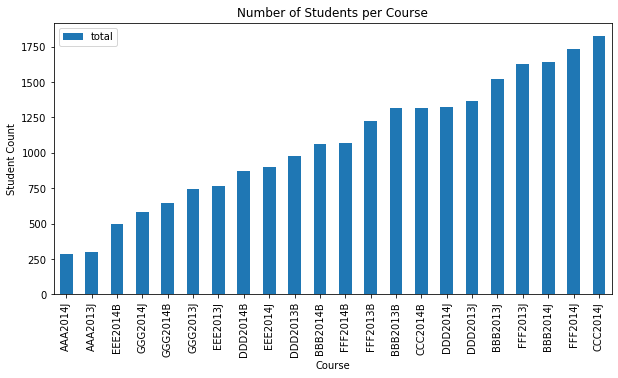

In [385]:
# create crosstab of result counts per module/presentation
modpres_res_counts = pd.crosstab(class_train['module_presentation'], values=class_train['result'], columns=class_train['result'], aggfunc='count')

# reset the index to be consecutive
modpres_res_counts = modpres_res_counts.reset_index()

# change datatypes or frequencies to work with
modpres_res_counts = modpres_res_counts.astype({'Distinction':int, 'Pass':int, 'Fail':int, 'Withdrawn':int})

# get total of results
modpres_res_counts['total'] = modpres_res_counts['Pass'] + modpres_res_counts['Fail'] + modpres_res_counts['Withdrawn'] + modpres_res_counts['Distinction']

# divide individual results by total and multiple by 100 to get frequencies
modpres_res_counts[['Distinction','Pass', 'Fail', 'Withdrawn']] = modpres_res_counts[['Distinction','Pass', 'Fail', 'Withdrawn']].div(modpres_res_counts['total'], axis=0) *100

# reorder columns
modpres_res_freq = modpres_res_counts[['module_presentation', 'Pass', 'Fail', 'Withdrawn', 'Distinction', 'total']]



# sort modules by number of results and plot
modpres_res_freq.sort_values(by='total').plot.bar(rot=90, x='module_presentation', y='total', title='Number of Students per Course', xlabel='Course', ylabel='Student Count', figsize=(10,5))

BBB, CCC, DDD and FFF courses seem to be the most popularwith AAA, GGG and EEE being least popular.

**Region**

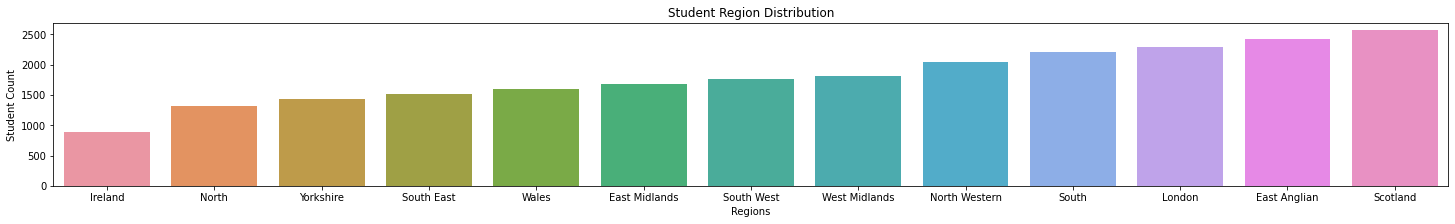

In [386]:
# sorts regions by number of students per regino
sorted_regions = class_train['region'].value_counts(ascending=True)

# plot a count plot of number of students per region in ascending order
plt.figure(figsize=(25, 3))
plt.title('Student Region Distribution')
sns.countplot(data=class_train, x=class_train['region'], order = sorted_regions.index).set(xlabel='Regions', ylabel='Student Count')
plt.show()

Here we can see the distribution of students by region. Our students come from various regions of the UK, Scotland, Ireland and Wales.

**IMD Band Counts**

[Text(0, 0.5, 'Student Count'), Text(0.5, 0, 'IMD Bands')]

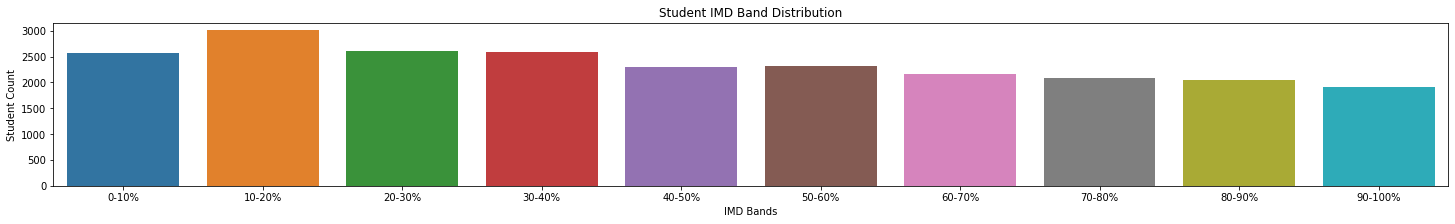

In [387]:
# sorted list of unique imd categories
imds = class_train[class_train['imd'].notna()]['imd'].sort_values().unique()

# create a count plot of number of students per imd band ordered by band valuesa
plt.figure(figsize=(25, 3))
plt.title('Student IMD Band Distribution')
sns.countplot(data=class_train, x=class_train['imd'], order=imds).set(xlabel='IMD Bands', ylabel='Student Count')

In this bar graph we see the distribution of students by IMD band. Many students seem to be in more deprived areas with a spike in students in the 10-20% band.

**Age Percentages**

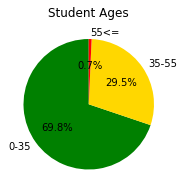

In [388]:
# ordered list of age_band possibilities
ages = class_train['age'].sort_values().unique()

# normalized value counts of age bands
age_freqs = class_train['age'].value_counts(normalize=True)

age_colors = ['green', 'gold', 'red']

# make a pie chart of age groups in our data
plt.figure(figsize=(25, 3))
plt.title('Student Ages')
plt.pie(data=class_train, x=age_freqs, labels=ages, autopct='%1.1f%%', startangle=90, colors=age_colors)
plt.show()

Nearly 70% of our students are under 35 and under 1% are age 55+

**Gender Counts**

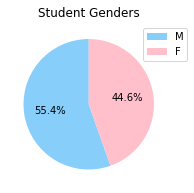

In [389]:
# list of possible genders in data
genders = ['M', 'F']

# get normalized value counts of genders in data
gender_freqs = class_train['gender'].value_counts(normalize=True)

gen_colors = ['lightskyblue', 'pink']

# make a pie chart of overall gender distribution
plt.figure(figsize=(25, 3))
plt.title('Student Genders')
plt.pie(data=class_train, x=gender_freqs, autopct='%1.1f%%', startangle=90, colors=gen_colors)
plt.legend(labels=genders, bbox_to_anchor=(.8,1), loc='upper left') 

Our genders are fairly evenly distributed with males being slightly more represented in our student sample.

**Education**

[Text(0, 0.5, 'Student Count'), Text(0.5, 0, 'Student Education Level')]

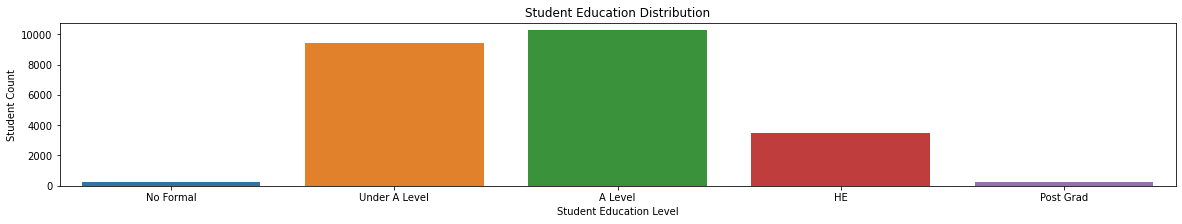

In [390]:
# list of education possibilities in order 
educations = ['No Formal', 'Under A Level', 'A Level', 'HE', 'Post Grad']

# create a bar graph/count plot of students per education level
plt.figure(figsize=(20, 3))
plt.title('Student Education Distribution')
sns.countplot(data=class_train, x=class_train['education'], order=educations).set(xlabel= 'Student Education Level', ylabel='Student Count')

Most of our students fall Under A Level or at A Level as their furthest education. Post Grad Students and students with no formal education are underrespresented.

**Disability Percentage**

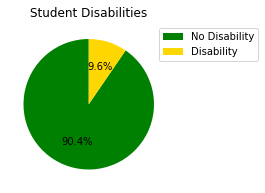

In [391]:
# ordered disability list
disabilities=['No Disability', 'Disability']

# get normalized value counts of disabilties in data
disability_freqs = class_train['disability'].value_counts(normalize=True)

dis_colors = ['green', 'gold']

# create pie chart of students with and without disabilities
plt.figure(figsize=(25, 3))
plt.title('Student Disabilities')
plt.pie(data=class_train, x=disability_freqs, autopct='%1.1f%%', startangle=90, colors=dis_colors)
plt.legend(labels=disabilities, loc='upper left', bbox_to_anchor=(.9,1))

Under 10% of our students identified as having disabilities and so are underrepresented in this group.

**Results Percentages**

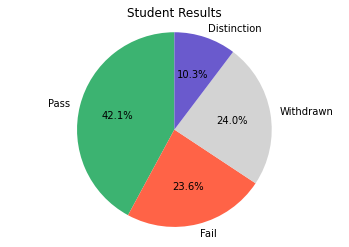

In [392]:
# list of result possibilities
results = ['Pass', 'Fail', 'Withdrawn', 'Distinction']

# get normalized value counts of results
result_freqs = class_train['result'].value_counts(normalize=True)

results_colors = ['MediumSeaGreen', 'Tomato', 'LightGray','SlateBlue']

# convert values to percentages
pass_perc = round((result_freqs[0] * 100), 1)
withdraw_perc = round((result_freqs[1] * 100), 1)
fail_perc = round((result_freqs[2] * 100), 1)
distinct_perc = round((result_freqs[3] * 100), 1)
results_percs = [pass_perc, fail_perc, withdraw_perc, distinct_perc]

# create pie chart of results by percentage
fig1, ax = plt.subplots()
ax.pie(results_percs, labels=results, autopct='%1.1f%%', startangle=90,colors=results_colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Student Results')
plt.show()

In [393]:
# get the percentage of students who failed or withdrew
neg_result = round(fail_perc + withdraw_perc)

# store the percentage of students who passed or passed with distinction
pos_result = round(pass_perc + distinct_perc)

md(f'''
Here we can see that we have a negative result of withdrawing or failing nearly **{neg_result}%** of the time,
with around **{pos_result}%** of students achieving a positive result of passing or passing with distinction.
''')


Here we can see that we have a negative result of withdrawing or failing nearly **48%** of the time,
with around **52%** of students achieving a positive result of passing or passing with distinction.


### Bivariate 

**Results per Module/Presentation**

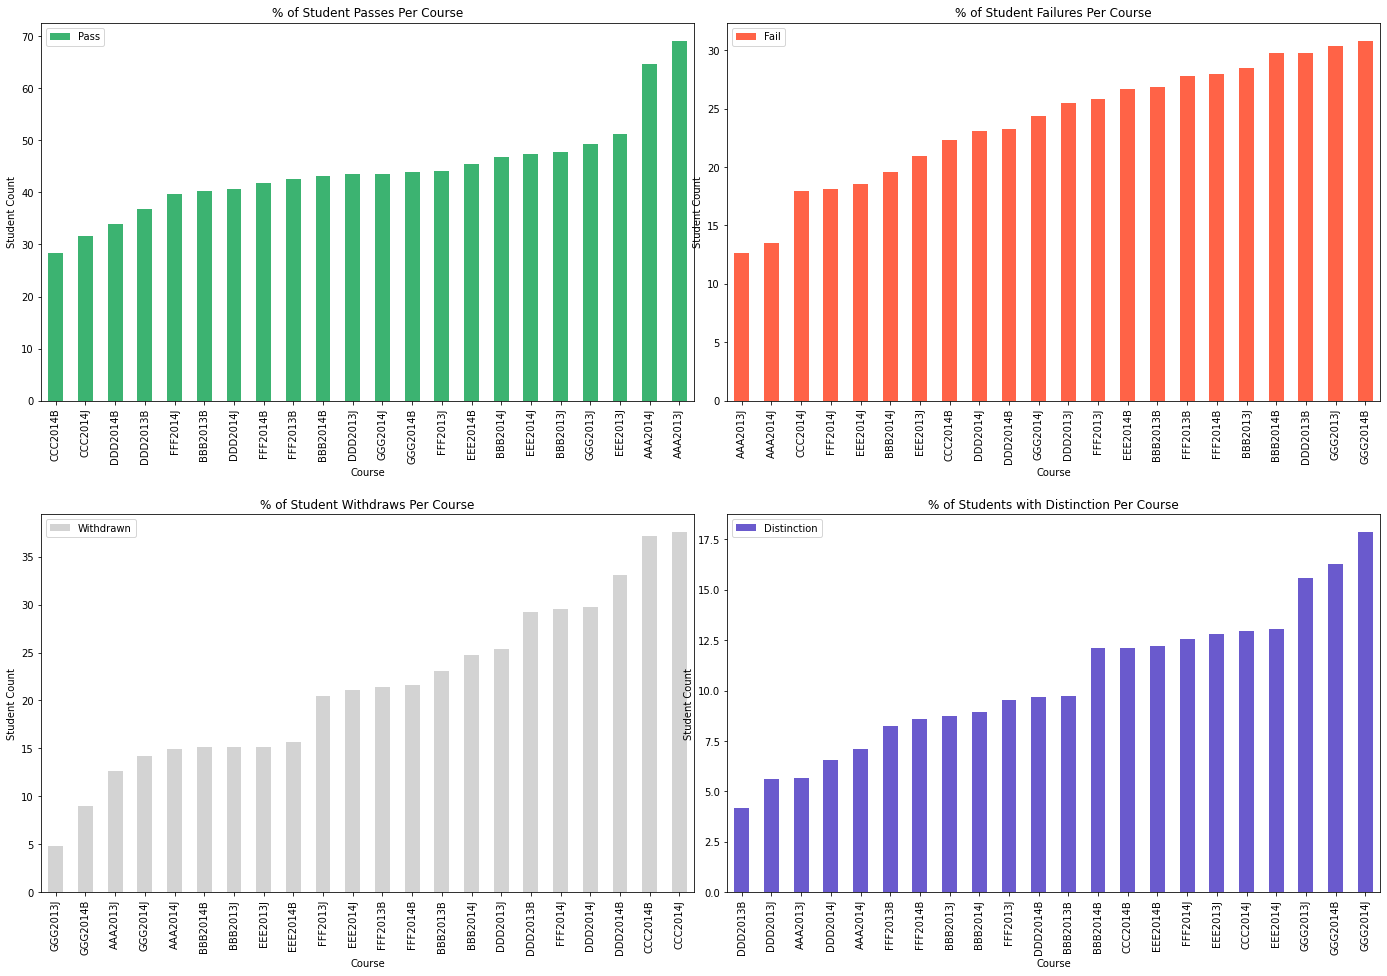

In [394]:
# create crosstab of result counts per module/presentation
modpres_res_counts = pd.crosstab(class_train['module_presentation'], values=class_train['result'], columns=class_train['result'], aggfunc='count')

# reset the index to be consecutive
modpres_res_counts = modpres_res_counts.reset_index()

# change datatypes or frequencies to work with
modpres_res_counts = modpres_res_counts.astype({'Distinction':int, 'Pass':int, 'Fail':int, 'Withdrawn':int})

# get total of results
modpres_res_counts['total'] = modpres_res_counts['Pass'] + modpres_res_counts['Fail'] + modpres_res_counts['Withdrawn'] + modpres_res_counts['Distinction']

# divide individual results by total and multiple by 100 to get frequencies
modpres_res_counts[['Distinction','Pass', 'Fail', 'Withdrawn']] = modpres_res_counts[['Distinction','Pass', 'Fail', 'Withdrawn']].div(modpres_res_counts['total'], axis=0) *100

# reorder columns
modpres_res_freq = modpres_res_counts[['module_presentation', 'Pass', 'Fail', 'Withdrawn', 'Distinction', 'total']]

# get bar charts of frequencies per result per module/presentation
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(24, 16) , nrows = nrows, ncols = ncols)
plt.subplots_adjust(wspace=.05, hspace=.3)
modpres_res_freq.sort_values(by='Pass').plot.bar(rot=90, ax=axes[0][0], x='module_presentation', y='Pass', title='% of Student Passes Per Course', xlabel='Course', ylabel='Student Count', color='MediumSeaGreen')
modpres_res_freq.sort_values(by='Fail').plot.bar(rot=90, ax=axes[0][1], x='module_presentation', y='Fail', title='% of Student Failures Per Course', xlabel='Course', ylabel='Student Count', color='Tomato')
modpres_res_freq.sort_values(by='Withdrawn').plot.bar(rot=90, ax=axes[1][0], x='module_presentation', y='Withdrawn', title='% of Student Withdraws Per Course', xlabel='Course', ylabel='Student Count', color='LightGray')
modpres_res_freq.sort_values(by='Distinction').plot.bar(rot=90, ax=axes[1][1], x='module_presentation', y='Distinction', title='% of Students with Distinction Per Course',xlabel='Course', ylabel='Student Count', color='SlateBlue')

Though the AAA module is the least popular, the students seem to have a noticably higher pass percentage in this course.

The GGG module has the lowest amount of withdrawals and the highest number of students who passed with distinction. It also has the highest number of failed students.

**Results per Module/Presentation**

We can see here that AAA modules had the highest percentage of students passing with GGG modules having the highest percent of failing students. The results of GGG could be that the full course weight of GGG is on that final exam giving students no chance to balance a poor final performance.

Also noticable here is that the courses which we noted had the highest amount of students have a high amount of failures and withdrawals. It would be interesting to see if class size had an effect on student success, so we will add the column `class_size` reflecting the size of the class each student is enrolled in.

In [395]:
class_size = class_train.pivot_table(values='id_student', index='module_presentation', aggfunc='count')
stud_info_train = class_train.merge(class_size, how='outer', on='module_presentation')
stud_info_test = class_test.merge(class_size, how='outer', on='module_presentation')
stud_info_train.rename(columns={'id_student_y':'class_size', 'id_student_x':'id_student'}, inplace=True)
stud_info_test.rename(columns={'id_student_y':'class_size', 'id_student_x':'id_student'}, inplace=True)


assessments_class_size = merged_assessments_info.merge(class_size, how='outer', on='module_presentation')
assessments_class_size.rename(columns={'id_student_y':'class_size', 'id_student_x':'id_student'}, inplace=True)
assessments_class_size = assessments_class_size.drop(columns='result')

# make train/test split of assessment data to avoid bias
reg_train, reg_test = train_test_split(assessments_class_size, test_size=0.2, random_state=42, stratify=assessments_class_size['module_presentation'])

**Results per Region**

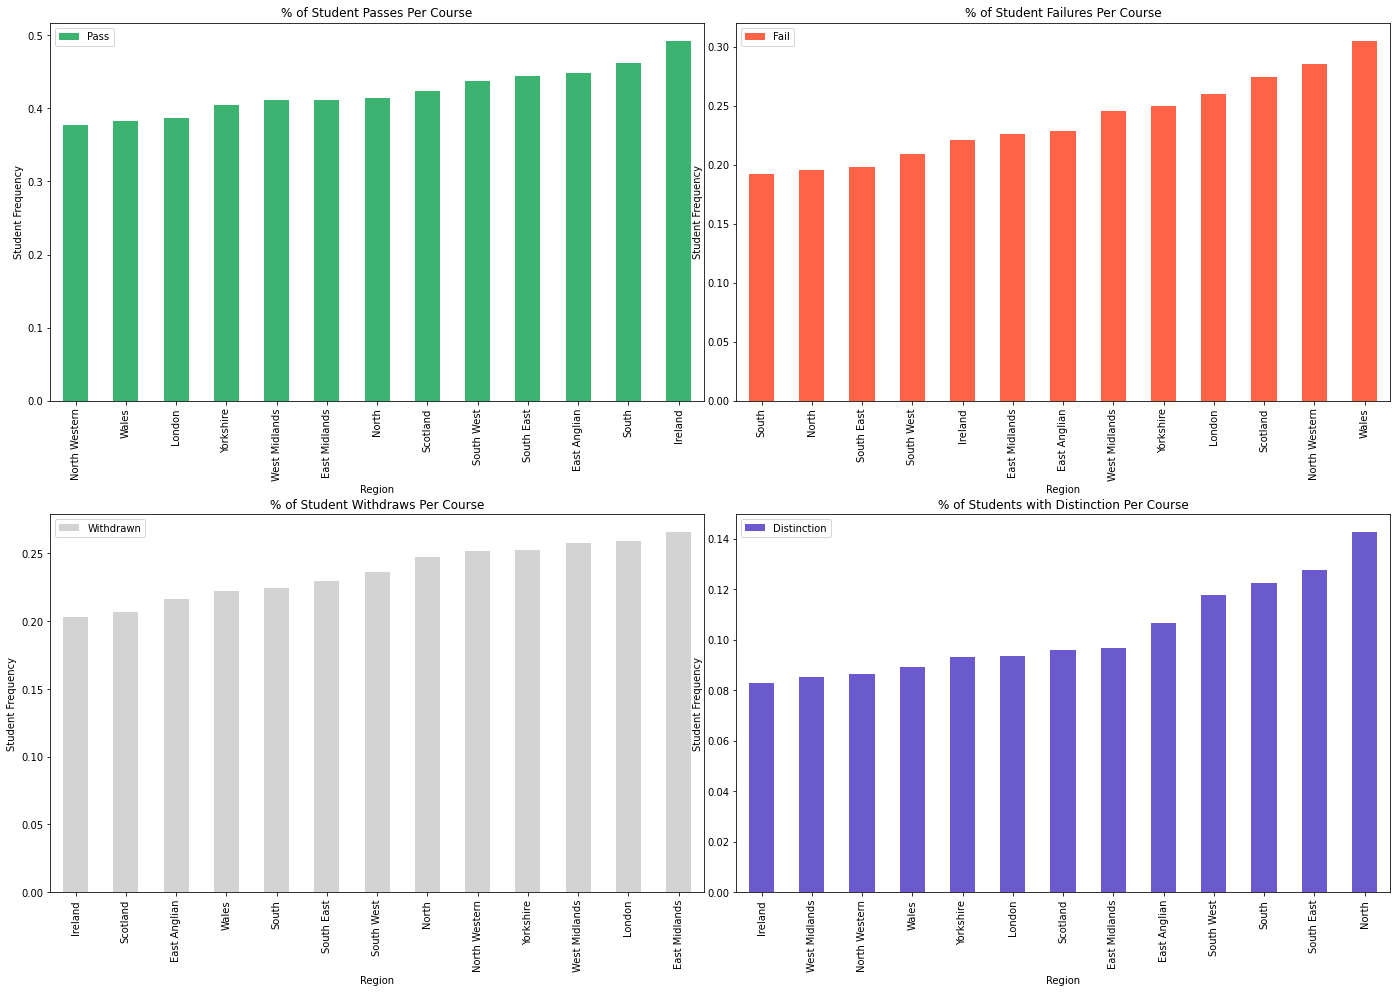

In [396]:
# get bar charts of frequencies per result per module/presentation
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(24, 16) , nrows = nrows, ncols = ncols)
plt.subplots_adjust(wspace=.05, hspace=.3)
region_res_freq = pd.crosstab(class_train['region'], values=class_train['result'], columns=class_train['result'], aggfunc='count', normalize='index').reset_index()
region_res_freq.sort_values(by='Pass').plot.bar(rot=90, ax=axes[0][0], x='region', y='Pass', title='% of Student Passes Per Course', xlabel='Region', ylabel='Student Frequency', color='MediumSeaGreen')
region_res_freq.sort_values(by='Fail').plot.bar(rot=90, ax=axes[0][1], x='region', y='Fail', title='% of Student Failures Per Course', xlabel='Region', ylabel='Student Frequency', color='Tomato')
region_res_freq.sort_values(by='Withdrawn').plot.bar(rot=90, ax=axes[1][0], x='region', y='Withdrawn', title='% of Student Withdraws Per Course', xlabel='Region', ylabel='Student Frequency', color='LightGray')
region_res_freq.sort_values(by='Distinction').plot.bar(rot=90, ax=axes[1][1], x='region', y='Distinction', title='% of Students with Distinction Per Course',xlabel='Region', ylabel='Student Frequency', color='SlateBlue')

Above we can see that Ireland, though it had the lowest number of students, had the highest percentage of students who passed, and the lowest percentage of withdrawals. Wales had the highest number of Failed students and the North had the highest number of distinctions. Let's now look at IMD bands and the results of students based on their IMD band. 

**Results per IMD Band**

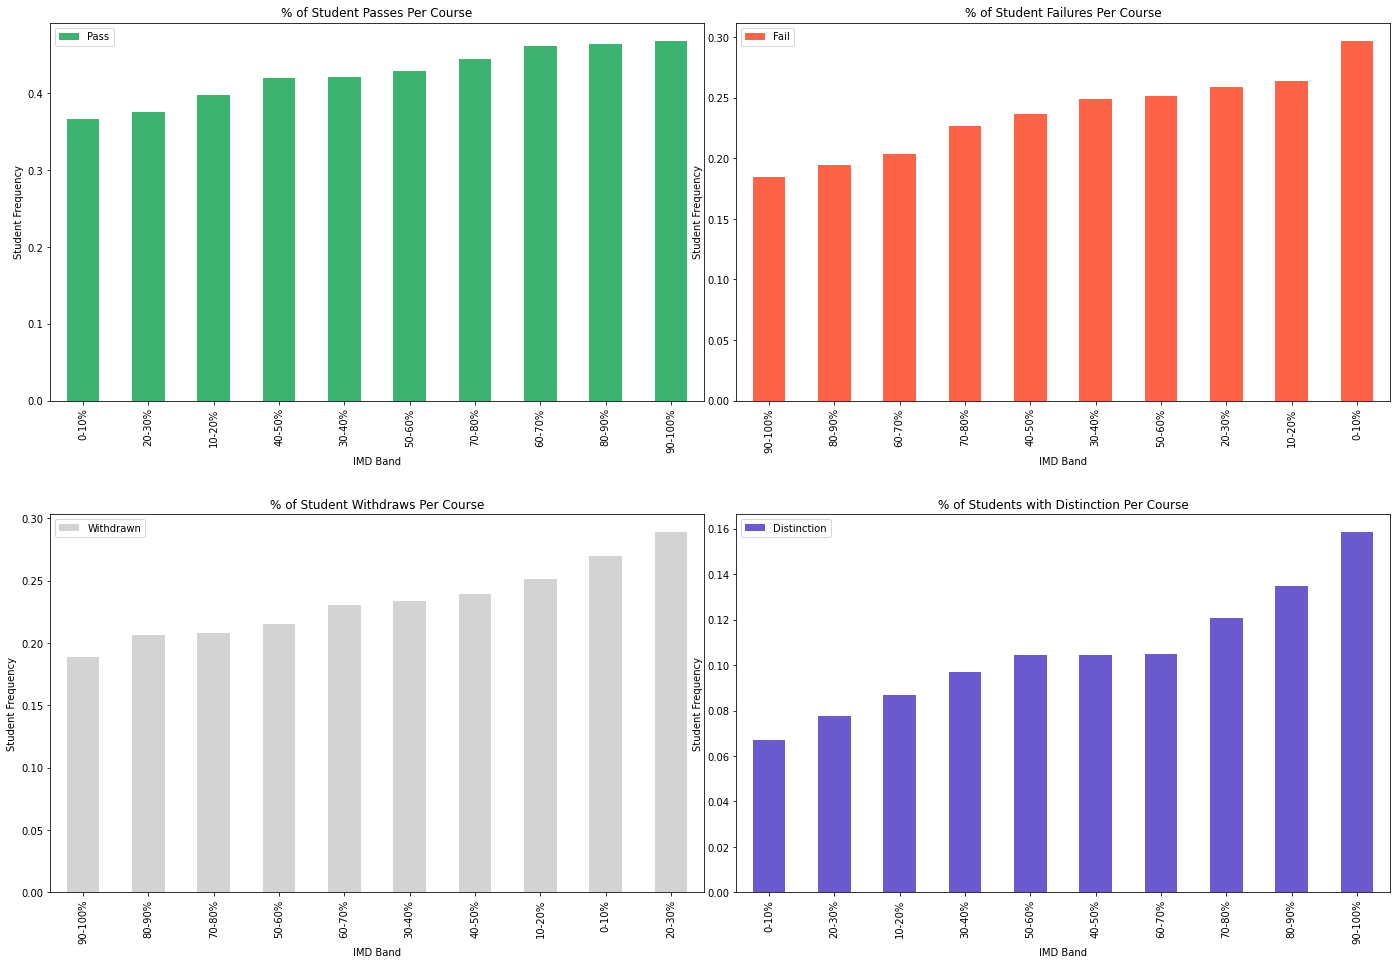

In [397]:

# get bar charts of frequencies per result per module/presentation
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(24, 16) , nrows = nrows, ncols = ncols)
plt.subplots_adjust(wspace=.05, hspace=.3)
imd_res_freq = pd.crosstab(class_train['imd'], values=class_train['result'], columns=class_train['result'], aggfunc='count', normalize='index').reset_index()
imd_res_freq.sort_values(by='Pass').plot.bar(rot=90, ax=axes[0][0], x='imd', y='Pass', title='% of Student Passes Per Course', xlabel='IMD Band', ylabel='Student Frequency', color='MediumSeaGreen')
imd_res_freq.sort_values(by='Fail').plot.bar(rot=90, ax=axes[0][1], x='imd', y='Fail', title='% of Student Failures Per Course', xlabel='IMD Band', ylabel='Student Frequency', color='Tomato')
imd_res_freq.sort_values(by='Withdrawn').plot.bar(rot=90, ax=axes[1][0], x='imd', y='Withdrawn', title='% of Student Withdraws Per Course', xlabel='IMD Band', ylabel='Student Frequency', color='LightGray')
imd_res_freq.sort_values(by='Distinction').plot.bar(rot=90, ax=axes[1][1], x='imd', y='Distinction', title='% of Students with Distinction Per Course',xlabel='IMD Band', ylabel='Student Frequency', color='SlateBlue')

It is clear here that students from more deprived areas are failing and withdrawing more. In fact it runs almost consecutively where the more deprived an area, the worse a student does and vice versa. 

**Results per Age Group**

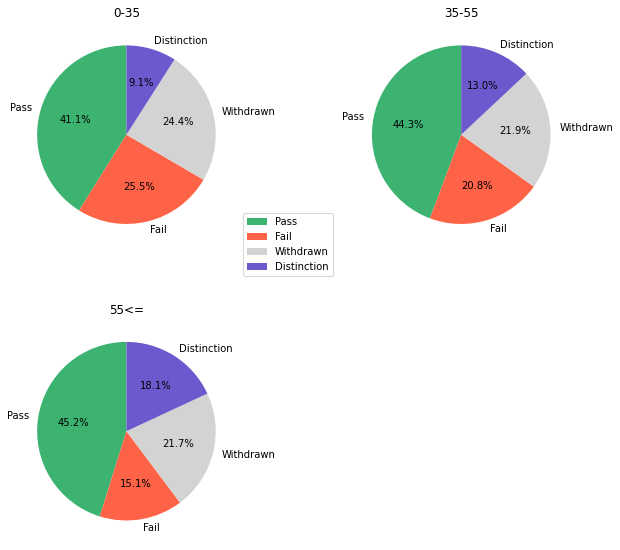

In [398]:
# get crosstab of student result counts per module/presentation
age_res_freq = pd.crosstab(class_train['age'], values=class_train['result'], columns=class_train['result'], aggfunc='count', normalize='index')

# ordered list of results
age_res_freq = age_res_freq[['Pass', 'Fail', 'Withdrawn', 'Distinction']]

# make pie charts of results per module/presentation
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (idx, row) in enumerate(age_res_freq.iterrows()):
    ax = axes[i // 2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, startangle=90, labels=results, autopct='%1.1f%%', colors=results_colors)
    ax.set_title(idx)
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]
    
ax.legend(labels=results, bbox_to_anchor=(1,1.5), loc='upper left') 
fig.subplots_adjust(wspace=.5)

Each age group has a very similar distribution of overall results. The noticable difference is older students seem to be more likely to pass with distinction.

**Results per Gender**

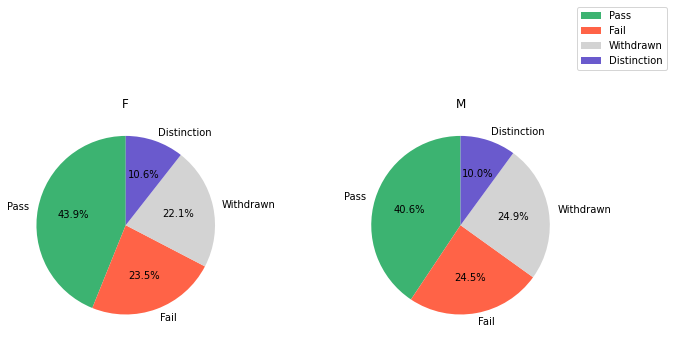

In [399]:
# get crosstab of student result counts per module/presentation
gen_res_freq = pd.crosstab(class_train['gender'], values=class_train['result'], columns=class_train['result'], aggfunc='count', normalize='index')

# ordered list of results
gen_res_freq = gen_res_freq[['Pass', 'Fail', 'Withdrawn', 'Distinction']]

# make pie charts of results per module/presentation
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (idx, row) in enumerate(gen_res_freq.iterrows()):
    ax = axes[i // 2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, startangle=90, labels=results, autopct='%1.1f%%', colors=results_colors)
    ax.set_title(idx)
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]
    
ax.legend(labels=results, bbox_to_anchor=(1,1.5), loc='upper left') 
fig.subplots_adjust(wspace=.5)

Each gender seems to perform similarly in courses.

**Results per disability**

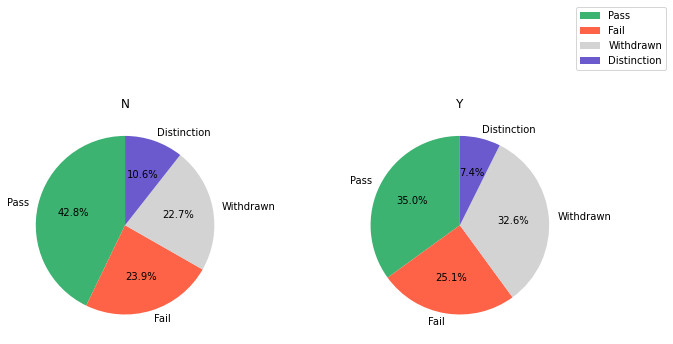

In [400]:
# get crosstab of student result counts per module/presentation
dis_res_freq = pd.crosstab(class_train['disability'], values=class_train['result'], columns=class_train['result'], aggfunc='count', normalize='index')

# ordered list of results
dis_res_freq = dis_res_freq[['Pass', 'Fail', 'Withdrawn', 'Distinction']]

# make pie charts of results per module/presentation
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (idx, row) in enumerate(dis_res_freq.iterrows()):
    ax = axes[i // 2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, startangle=90, labels=results, autopct='%1.1f%%', colors=results_colors)
    ax.set_title(idx)
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]
    
ax.legend(labels=results, bbox_to_anchor=(1,1.5), loc='upper left') 
fig.subplots_adjust(wspace=.5)

Disabled students do not seem to be failing much more frequently, but the withdrawal rate is much higher in students who identify as having a disability.

**Gender per Module**

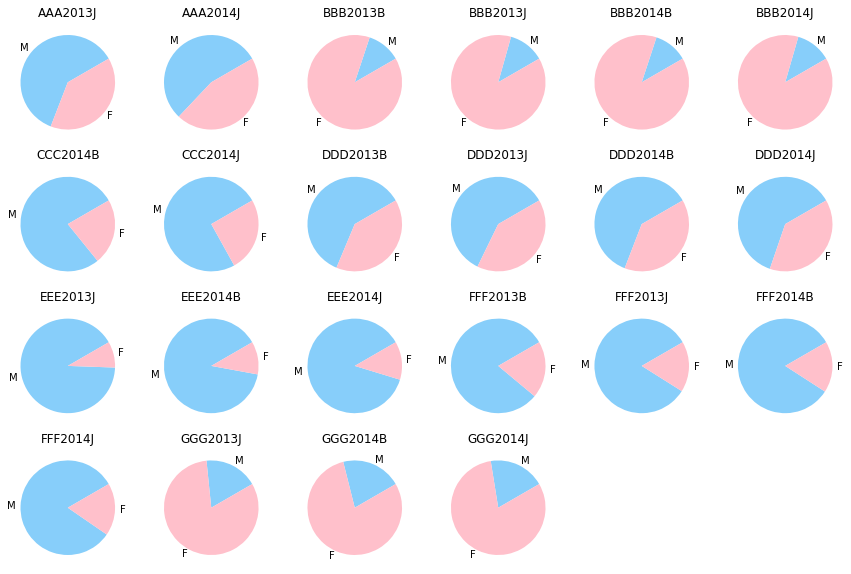

In [401]:
# makes a crosstab of genders per module/presentation
gender_res_freq = pd.crosstab(class_train['module_presentation'], values=class_train['gender'], columns=class_train['gender'], aggfunc='count', normalize='index')

# order the genders
gender_res_freq = gender_res_freq[['M','F']]

# make a pie chart of gender distribution per module/presentation
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

for i, (idx, row) in enumerate(gender_res_freq.iterrows()):
    ax = axes[i // 6, i % 6]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, startangle=30, colors=['lightskyblue', 'pink'])
    ax.set_title(idx)
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]

fig.subplots_adjust(wspace=.2)

It seems GGG and BBB courses attract many more females than males, while The rest of the courses are dominated by male students.

**Age per Module**

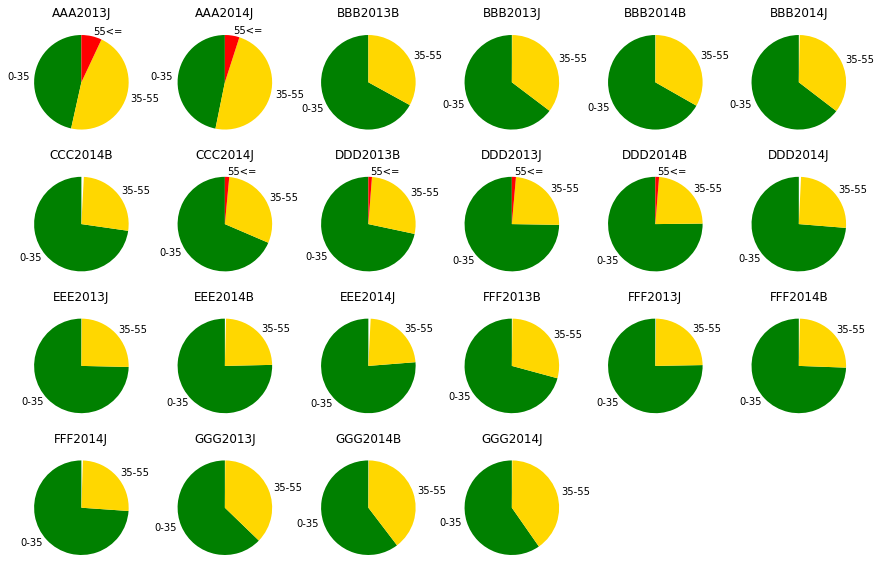

In [402]:
# make crosstab of counts of student ages per module/presentation
stud_age_freq = pd.crosstab(class_train['module_presentation'], values=class_train['age'], columns=class_train['age'], aggfunc='count', normalize='index')

# make a pie chart for each module_presentation of counts of student ages

fig, axes = plt.subplots(4, 6, figsize=(15, 10))

for i, (idx, row) in enumerate(stud_age_freq.iterrows()):
    ax = axes[i // 6, i % 6]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, startangle=90, colors=['green', 'gold', 'red'])
    ax.set_title(idx)
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]

fig.subplots_adjust(wspace=.2)

It seems that many of our students over 35 were interested in the AAA class which also contains the bulk of our 55+ students. There is also a higher representation of older students in the BBB and GGG courses. The rest of the courses are, as expected, dominated by younger students.

**Scores per Assessment Type**

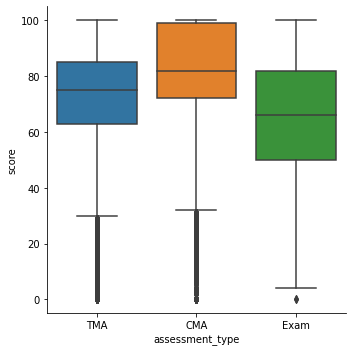

In [403]:
# make a box plot of each assessment type and their scores
sns.catplot(x='assessment_type', y='score', data=reg_train, kind='box')

According to our data computer marked exams get the best average scores, followed by the tutor marked exams and then the final exams.

**Sum of Clicks to Assessment Scores**

In [404]:
# store the correlation coef of sum_click to score
click_to_score = reg_train['sum_click'].astype(int).corr(reg_train['score'].astype(int))

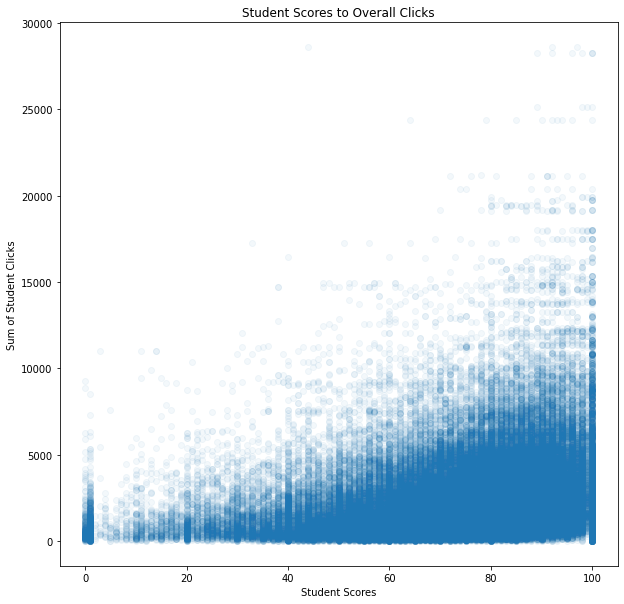

In [405]:
# make a scatter plot of sum click to score
plt.figure(figsize=(10, 10))
plt.title('Student Scores to Overall Clicks')
plt.xlabel("Student Scores")
plt.ylabel("Sum of Student Clicks")
plt.scatter(data=reg_train, y='sum_click', x='score', alpha=.05)

In [406]:


md(f'''
There is a very weak positive correlation according to our correlational coefficient of {round(click_to_score, 2)} between
with the sum of clicks and student score. Interestingly there is a spike of scores at 0 where it looks like students with 
no clicks do better than students with around 5-20 clicks. Let's take a look at these students who have high scores, but low clicks.
''')


There is a very weak positive correlation according to our correlational coefficient of 0.16 between
with the sum of clicks and student score. Interestingly there is a spike of scores at 0 where it looks like students with 
no clicks do better than students with around 5-20 clicks. Let's take a look at these students who have high scores, but low clicks.


In [407]:
# dataframe of students who had a sum click of under 1000 
reg_train[reg_train['sum_click'] < 1000].sort_values('score', ascending=False).head(40)

,id_assessment,id_student,date_submitted,score,module,presentation,assessment_type,date,weight,module_presentation,sum_click,avg_click,_merge,region,imd,age,gender,education,disability,date_registration,attempts,credits,class_size
21662,15003,579316,56,100,BBB,2013J,CMA,54,1.0,BBB2013J,109,2.27,both,West Midlands,50-60%,0-35,F,A Level,N,-74,0,60,1521
24291,15003,597301,56,100,BBB,2013J,CMA,54,1.0,BBB2013J,651,2.46,both,South West,80-90%,0-35,F,Under A Level,N,-62,0,120,1521
145038,37419,599815,178,100,GGG,2013J,CMA,229,0.0,GGG2013J,673,3.35,both,South,70-80%,0-35,F,A Level,N,-29,0,30,744
27057,15003,616342,56,100,BBB,2013J,CMA,54,1.0,BBB2013J,515,2.35,both,Wales,40-50%,0-35,M,A Level,N,-11,0,120,1521
35482,15015,148427,49,100,BBB,2014B,CMA,47,1.0,BBB2014B,421,1.73,both,South East,20-30%,0-35,F,A Level,N,-113,0,120,1059
30198,15017,613170,119,100,BBB,2014B,CMA,117,1.0,BBB2014B,555,2.27,both,South West,80-90%,0-35,F,Under A Level,N,-138,0,60,1059
153522,37441,643970,200,100,GGG,2014J,CMA,229,0.0,GGG2014J,707,3.86,both,Wales,20-30%,0-35,F,Under A Level,Y,-120,0,30,583
8644,14995,516057,189,100,BBB,2013B,CMA,187,1.0,BBB2013B,760,2.75,both,South East,50-60%,0-35,F,A Level,Y,-30,0,60,1315
143956,37421,590034,208,100,GGG,2013J,CMA,229,0.0,GGG2013J,476,3.84,both,South,70-80%,0-35,F,Under A Level,N,-64,0,30,744
4982,14995,247267,189,100,BBB,2013B,CMA,187,1.0,BBB2013B,559,2.32,both,South East,70-80%,0-35,M,Under A Level,N,-79,0,60,1315


So taking a look at the top 40 scores in students who had a sum_click under 20 but great scores, it looks like many are from the BBB module, the date submitted was either -1, the day before the course began, or otherwise very early in the course and the weight of these exams were zero to one. Perhaps this exam was one where students could not get wrong answers. Let's pick one of these zero weight exams and see what scores other students received.

In [408]:
# dataframe of students with 15003 assessment id and their scores
dataframe(reg_train[reg_train['id_assessment'] =='15003'].sort_values('score')['score'].value_counts())

,score
100,872
80,248
60,51
40,9


So while this was probably an easy exam as so many students got 100 points, some did not. It is exams like this that are causing our spike at zero though.

The relationship between average clicks is likely to be similar, but let's see what we can see.

**Average Clicks to Assessment Scores**

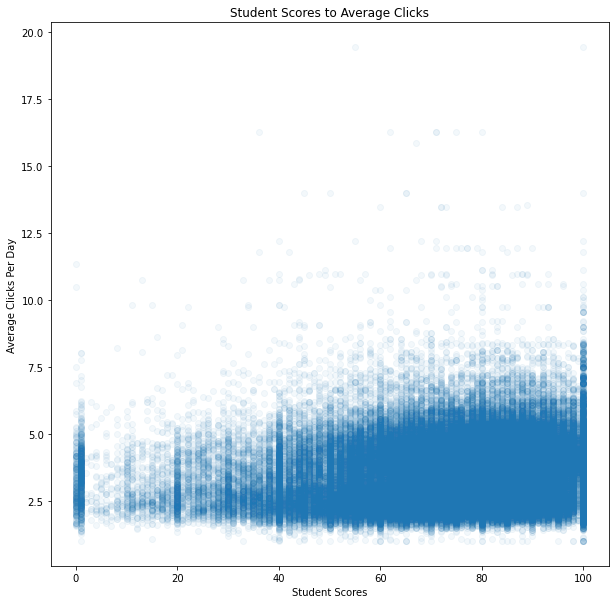

In [409]:
# make a scatter plot of average click to score
plt.figure(figsize=(10, 10))
plt.title('Student Scores to Average Clicks')
plt.xlabel("Student Scores")
plt.ylabel("Average Clicks Per Day")
plt.scatter(data=reg_train, y='avg_click', x='score', alpha=.05)

In [410]:
avg_click_to_score = reg_train['avg_click'].astype(int).corr(reg_train['score'].astype(int))

md(f'''
The same relationship seems to hold, where average clicks per day seem to be related to increased scores with a very weak, positive
relationship of {round(avg_click_to_score,2)} but the overall effects seem to have a peak at around 6 clicks per day, where after 
that there is not much of a score increase per average click.  Students who got 100s on their exams do seem to have a much higher 
click average than their peers where many students seem to average a higher amount of clicks per day
''')


The same relationship seems to hold, where average clicks per day seem to be related to increased scores with a very weak, positive
relationship of 0.08 but the overall effects seem to have a peak at around 6 clicks per day, where after 
that there is not much of a score increase per average click.  Students who got 100s on their exams do seem to have a much higher 
click average than their peers where many students seem to average a higher amount of clicks per day


The same relationship seems to hold, where average clicks per day seem to be related to increased scores, but the overall effects seem to have a peak at around 6 clicks per day, where after that there is not much of a score increase per average click. Students who got 100s on their exams do seem to have a much higher click average than their peers where many students seem to have 7-9 interactions with resources per day.

**Score to Module**

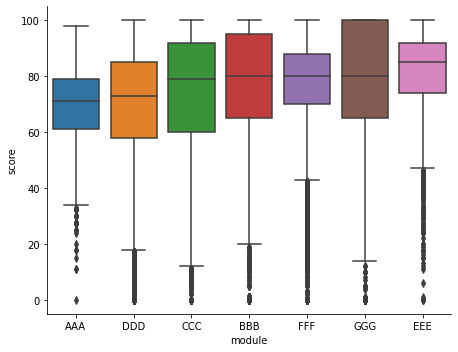

In [411]:
# make a catplot/boxplot of module scores sorted in ascending order
sorted_mod_score = reg_train.groupby(by=['module'])['score'].mean().sort_values().index
sns.catplot(x='module', y='score', data=reg_train, kind='box',order=sorted_mod_score, aspect=10.7/8.27)

Students in the AAA module, despite getting overall better results than students in other modules seem to have the lowest average scores.

It seems that EEE, FFF and GGG have generally higher exam scores. 

**Click Sum per Module**

Let's take a look at each modules clicks per student

In [412]:
# make a pivot table of student class size and sum click to get the clicks per student per module
clicks_per_stud = reg_train.pivot_table(index='module', values=['sum_click', 'class_size'], aggfunc='sum')
clicks_per_stud['click_per_student'] = clicks_per_stud['class_size'].div(clicks_per_stud['sum_click'])
clicks_per_stud = clicks_per_stud.reset_index()

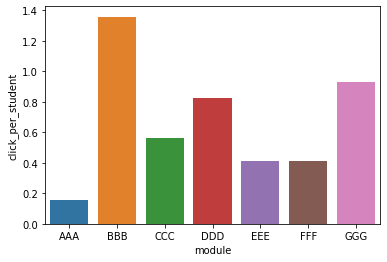

In [413]:
# make a barplot the clicks of student per module
sns.barplot(x='module', y='click_per_student', data=clicks_per_stud)

AAA has the lowest engagement per student and BBB has the highest. Again GGG seems to have had good student engagement and likely would have had many more passing students if the exams were weighted differently.

**Assessment Weight to Score**

In [414]:
# get the correlation coef between exam weight and score
weight_to_score = reg_train['weight'].astype(int).corr(reg_train['score'].astype(int))

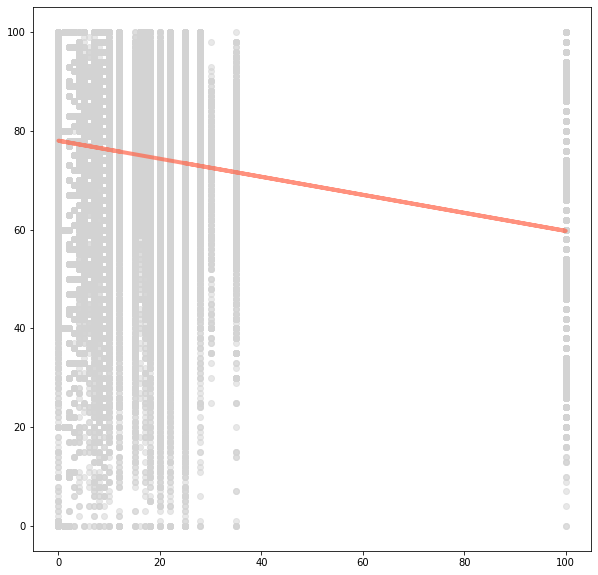

In [415]:
# Make a scatterplot for exam weight to score
plt.figure(figsize=(10, 10))
x = np.array(reg_train['weight'].astype(int))
y = np.array(reg_train['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# add a line of best fit to scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

In [416]:
md(f'''
There is a very weak negative correlation of {round(weight_to_score)}, so It does seem as the assessment weight increases 
the average score goes down. There is a large gap in our data though since the non-final exams only go up to weight 35. 
This might dramatize our relationship here. Let's see if this relationship holds true for exams under weight 100
''')


There is a very weak negative correlation of 0, so It does seem as the assessment weight increases 
the average score goes down. There is a large gap in our data though since the non-final exams only go up to weight 35. 
This might dramatize our relationship here. Let's see if this relationship holds true for exams under weight 100


In [417]:
under_50_weight = reg_train.loc[reg_train['weight'] < 100]
under_50_weight_to_score = under_50_weight['weight'].astype(int).corr(under_50_weight['score'].astype(int))

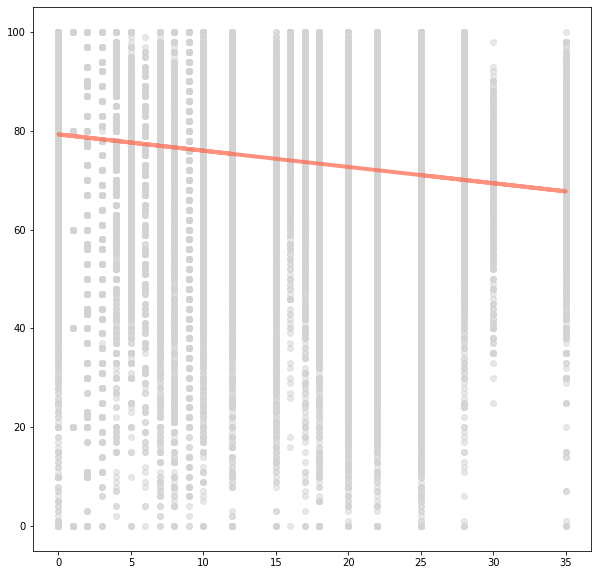

In [418]:
# create a scatterplot of the exam weight to score of exams weighted under 50
plt.figure(figsize=(10, 10))
x = np.array(under_50_weight['weight'].astype(int))
y = np.array(under_50_weight['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# add a line of best fit to scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

In [419]:
md(f'''
Indeed the exam scores do seem to get worse as the weight of the exams increases as we see here with a correlational coefficient of 
{round(under_50_weight_to_score, 2)}. We know the weight of the final exams is always 100,  let's see the average weight of the tutor marked exams.
''')


Indeed the exam scores do seem to get worse as the weight of the exams increases as we see here with a correlational coefficient of 
-0.17. We know the weight of the final exams is always 100,  let's see the average weight of the tutor marked exams.


In [420]:
# create a table of the average weight of an exam per assessment type
pd.pivot_table(reg_train, index='assessment_type', values='weight', aggfunc='mean')

,weight
assessment_type,
CMA,1.307277
Exam,100.000000
TMA,16.281425


The tutor marked exams carry a significantly higher weight than the computer marked exams

**Assessment Date to Score**

In [421]:
# get the corr coef of date to score
date_to_score = reg_train['date'].astype(int).corr(reg_train['score'].astype(int))

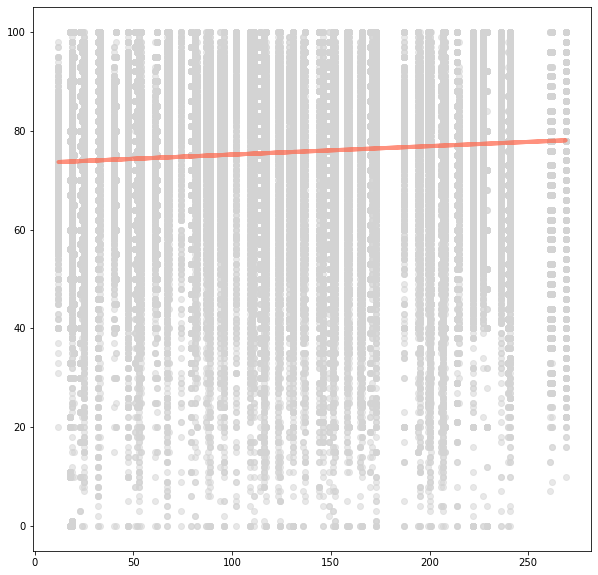

In [422]:
# create a scatterplot of date to score relationship
plt.figure(figsize=(10, 10))
x = np.array(reg_train['date'].astype(int))
y = np.array(reg_train['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# add a line of best fit to scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

According to our line of best fit the assessment scores are getting slightly better over time. 

**Date Submitted to Score**

In [423]:
# get the corr coef of date submitted to score
date_sub_to_score = reg_train['date_submitted'].astype(int).corr(reg_train['score'].astype(int))

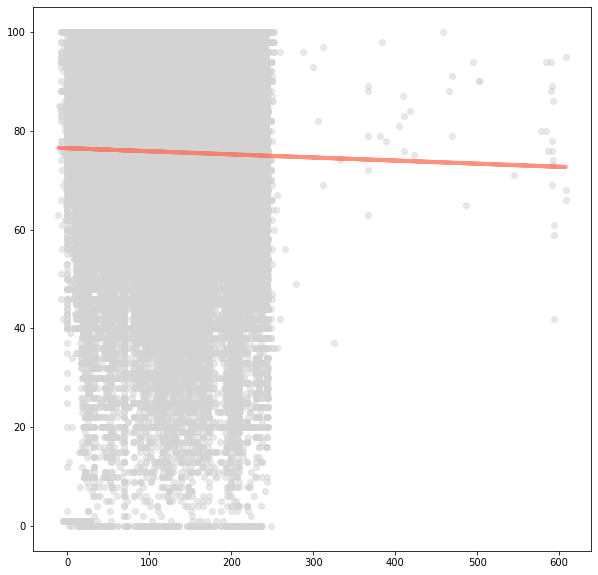

In [424]:
# create a scatterplot of date submitted to score relationship
plt.figure(figsize=(10, 10))
x = np.array(reg_train['date_submitted'].astype(int))
y = np.array(reg_train['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# add a line of best fit to scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

It seems as the date submitted gets later and later, student scores get worse and worse.

Let's see how, how many days late an assignment is affects the score by adding a column to indicate how many days late an assessment was by subtracting the `date` from `date_submitted`

**Lateness to Score**

In [425]:
# create a 'days_late' column by subtracting the date of the exam from the date the exam was submitted in both sets
reg_train['days_late'] = reg_train['date_submitted'] - reg_train['date']
reg_test['days_late'] = reg_test['date_submitted'] - reg_test['date']

In [426]:
# get the corr coef of latess to score
lateness_to_score = reg_train['days_late'].astype(int).corr(reg_train['score'].astype(int))

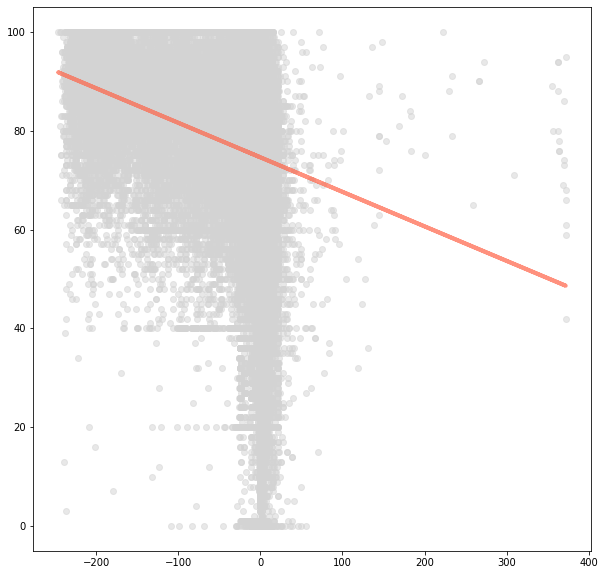

In [427]:
# create a scatterplot of exam lateness to score relationship
plt.figure(figsize=(10, 10))
x = np.array(reg_train['days_late'].astype(int))
y = np.array(reg_train['score'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# add a line of best fit to scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

We can see here that students who turned in their exams earlier clearly got much better scores, and the lter the turn in the worse the score trended toward. We also see that a great deal of students submitted their exams on time or early.

**Age to Score**

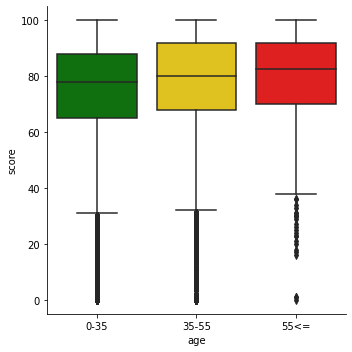

In [428]:
# make a catplot/boxplot of student age band vs their scores sorted in ascending order by score mean
sns.catplot(x='age', y='score', data=reg_train, kind='box', palette=age_colors)

The older the student, the higher the mean score though not incredibly significantly.

**Gender to Score**

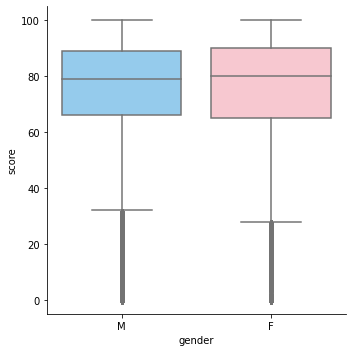

In [429]:
# make a catplot/boxplot of student gender vs their scores sorted in ascending order by score mean
sns.catplot(x='gender', y='score', data=reg_train, kind='box', palette=gen_colors)

Each gender is performing similarly on exams score-wise with females having a slightly higher average score.

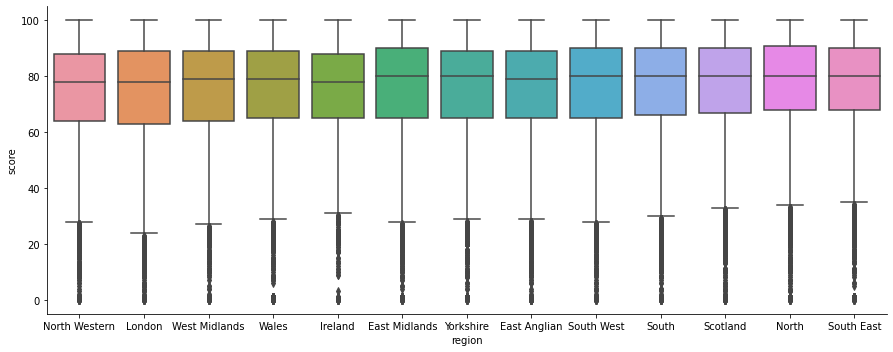

In [430]:
# make a catplot/boxplot of student region vs their scores sorted in ascending order by score mean
sorted_region_mean = reg_train.groupby(by=['region'])['score'].mean().sort_values().index
sns.catplot(x='region', y='score', data=reg_train, kind='box', aspect=20.7/8.27, order=sorted_region_mean)

The mean score per region is similar across the board.

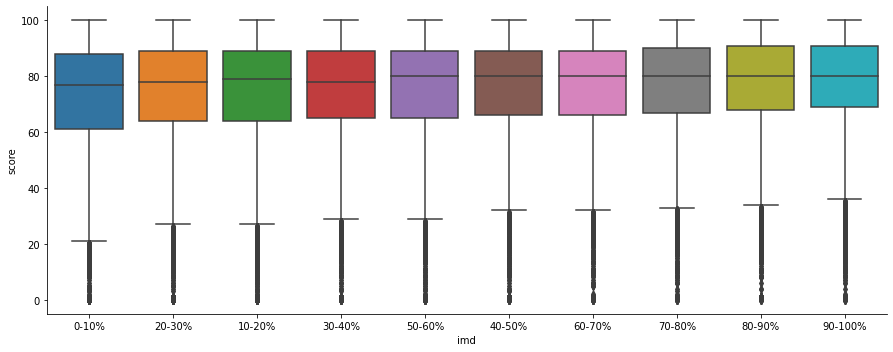

In [431]:
# make a catplot/boxplot of student IMD bands vs their scores sorted in ascending order by mean
sorted_imd_mean = reg_train.groupby(by=['imd'])['score'].mean().sort_values().index
sns.catplot(x='imd', y='score', data=reg_train, kind='box', order=sorted_imd_mean, aspect=20.7/8.27)

The mean assessment score goes up with IMD Band similar to what we saw in results.

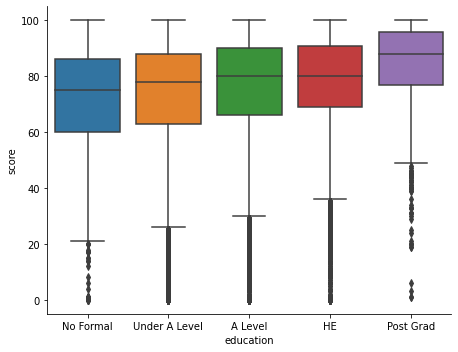

In [432]:
# make a catplot/boxplot of student education vs their scores sorted in ascending order by mean
sorted_edu_mean = reg_train.groupby(by=['education'])['score'].mean().sort_values().index
sns.catplot(x='education', y='score', data=reg_train, kind='box',order=sorted_edu_mean, aspect=10.7/8.27)

The mean score imporoves notably with education.

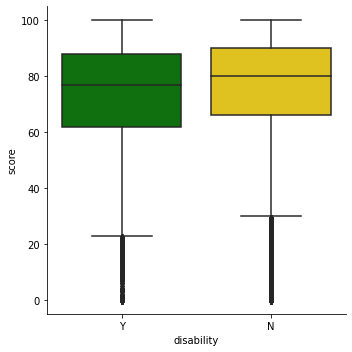

In [433]:
# make a catplot/boxplot of scores per disability category sorted in ascending order by mean
sns.catplot(x='disability', y='score', data=reg_train, kind='box', palette=dis_colors)

**Clicks per Resource**

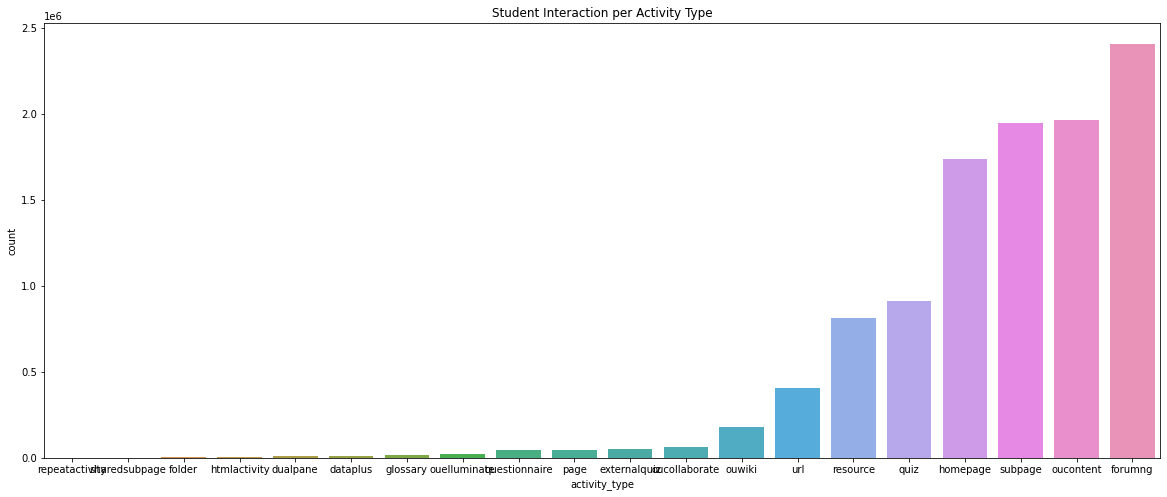

In [434]:
# create a barchart of the resources students interacted with sorted by number of interactions in ascending order
plt.figure(figsize=(20, 8))
plt.title('Student Interaction per Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Interaction Count')
sns.countplot(data=merged_vle, x='activity_type', order = merged_vle['activity_type'].value_counts(ascending=True).index)

The most popular area seems to be forums where students can interact. "oucontent" stands for "Open University" content which is the source of our data. This is the meat and potatoes of Open University and is how students learn. The homepage of course is going to be a frequent click as well as subpages of the Open University. Quizzes, and resources are made available to students as well at the Open University Wiki. After this, the student interactions with certain resources grow less and less significant. 

**Clicks Over Time**

In [435]:
# store  first quantile of sum_click
Q1 = merged_vle['sum_click'].astype(float).quantile(0.25)

# store third quantile of sum_click
Q3 = merged_vle['sum_click'].astype(float).quantile(0.75)

# get IQR of sum_click by subtracting 1st from 3rd quantile
IQR = Q3 - Q1

# subset only non-outliers from click data
vle_no_outliers = merged_vle[~(merged_vle['sum_click'] > (Q3 + 1.5 * IQR))]

# get the clicks per day without the outliers in pivot table
clicks_per_day = vle_no_outliers.pivot_table(vle_no_outliers, index='date', aggfunc='sum').reset_index()

In [436]:
# get corr coef of clicks to date without outliers
clicks_to_date = reg_train['days_late'].astype(int).corr(merged_assessments['score'].astype(int))

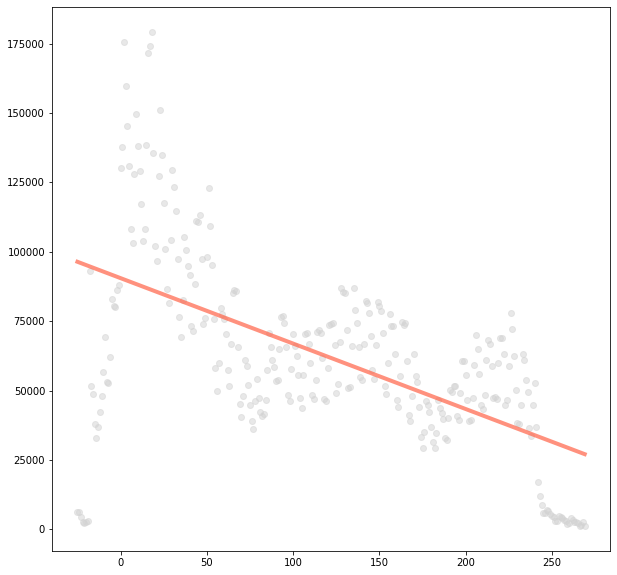

In [437]:
# make a pivot table of click sum per day overall for students and plot it in a scatterplot
clicks_per_day = vle_no_outliers.pivot_table(vle_no_outliers, index='date', aggfunc='sum').reset_index()
plt.figure(figsize=(10, 10))
x = np.array(clicks_per_day['date'].astype(int))
y = np.array(clicks_per_day['sum_click'].astype(int))
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, alpha=.5, color='lightgrey')
# make a line of best fit for scatterplot
plt.plot(x, m*x + b, color='tomato', lw=4, alpha=.7)

The clicks per day overall start quite high, but decrease sharply up until day 75 when they start to go up and then drop again around day 150 repeating this pattern until the end of the modules. It is interesting that it is every 75 days that student interest reaches a low point, and then rises again.

Final Cleaning

* For ages we see that there is less than 1% of people in the 55 and over range and so we will combine that with the 35-55 range to make two ranges: 0-35 and 35+

* We will be using classification to identify students as having negative or positive results and so will identify `Distinction` and `Pass` as positive results which we will label as boolean True and `Fail` and `Withdrawn` as negative results which we will label as boolean False. This will be done in another column.

* We can merge the courses and student information data frames to add the course length to student information as a potential predictor of student success.

* We can then merge the assessments and student information dataframes to add student demographical information, and the course length as potential predictors of student assessment scores.

* We will merge the VLE and student outcome data (pass, fail, withdrawn, distinction) to predict student outcomes based on resource interaction.

In [438]:
# replace ages and results values to be more model-friendly in train and test set for si
si_train = stud_info_train.replace({'age':{'55<=':'35+', '35-55':'35+'}, 'result':{'Pass':'Pos','Fail':'Neg','Distinction':'Pos','Withdrawn':'Neg'}})
si_test = stud_info_test.replace({'age':{'55<=':'35+', '35-55':'35+'}, 'result':{'Pass':'Pos','Fail':'Neg','Distinction':'Pos','Withdrawn':'Neg'}})

# create course_length column in test/train set
si_train['course_length'] = 0
si_test['course_length'] = 0

# assign course_length from courses dataframe to training set for appropriate module/presentation
for index, row in si_train.iterrows():
    # change assessments date at current index to the course_length found in courses by locating the matching module/presentation
    si_train.at[index, 'course_length'] = courses.loc[(courses['module'] == row['module']) & (courses['presentation'] == row['presentation']), 'course_length']

# assign course_length from courses dataframe to testing set for appropriate module/presentation
for index, row in si_test.iterrows():
    si_test.at[index, 'course_length'] = courses.loc[(courses['module'] == row['module']) & (courses['presentation'] == row['presentation']), 'course_length']

# change 
si_train = si_train.astype({'region':'category', 'imd':'category', 'education':'category', 'disability':'category', 'gender':'category', 'result':'category', 'age':'category'})
si_test = si_test.astype({'region':'category', 'imd':'category', 'education':'category', 'disability':'category', 'gender':'category', 'result':'category', 'age':'category'})

# change order of rows to remove target/to make sense
si_train = si_train[['region', 'imd', 'age', 'gender', 'education', 'disability', 'date_registration', 'attempts', 'credits', 'class_size', 'course_length', 'sum_click', 'avg_click', 'result']]
si_test = si_test[['region', 'imd', 'age', 'gender', 'education', 'disability', 'date_registration', 'attempts', 'credits', 'class_size', 'course_length', 'sum_click', 'avg_click', 'result']]


In [439]:
pd.set_option('display.max_columns', None)

# replace ages and results values to be more model-friendly in train and test set for reg
reg_train = reg_train.replace({'age':{'55<=':'35+', '35-55':'35+'}, 'result':{'Pass':'Pos','Fail':'Neg','Distinction':'Pos','Withdrawn':'Neg'}})
reg_test = reg_test.replace({'age':{'55<=':'35+', '35-55':'35+'}, 'result':{'Pass':'Pos','Fail':'Neg','Distinction':'Pos','Withdrawn':'Neg'}})

# remove any rows that are not properly merged
reg_train = reg_train[reg_train['_merge'] == 'both']
reg_test = reg_test[reg_test['_merge'] == 'both']

# create course_length column in test/train set
reg_train['course_length'] = 0
reg_test['course_length'] = 0

# assign course_length from courses dataframe to training set for appropriate module/presentation
for index, row in reg_train.iterrows():
    reg_train.at[index, 'course_length'] = courses.loc[(courses['module'] == row['module']) & (courses['presentation'] == row['presentation']), 'course_length']

# assign course_length from courses dataframe to testing set for appropriate module/presentation
for index, row in reg_test.iterrows():
    reg_test.at[index, 'course_length'] = courses.loc[(courses['module'] == row['module']) & (courses['presentation'] == row['presentation']), 'course_length']

# drop columns that are not for prediction
assm_train = reg_train.drop(columns=['_merge', 'module', 'presentation', 'module_presentation', 'id_student', 'id_assessment'])
assm_test = reg_test.drop(columns=['_merge', 'module', 'presentation', 'module_presentation', 'id_student', 'id_assessment'])

assm_train = assm_train.astype({'region':'category', 'imd':'category', 'education':'category', 'disability':'category', 'gender':'category', 'age':'category', 'assessment_type':'category'})
assm_test = assm_test.astype({'region':'category', 'imd':'category', 'education':'category', 'disability':'category', 'gender':'category', 'age':'category', 'assessment_type':'category'})

# change order of rows to remove target/to make sense
assm_train = assm_train[['region', 'imd', 'age', 'gender', 'education', 'disability', 'date_registration', 'attempts', 'credits', 'class_size', 'course_length', 'sum_click', 'avg_click', 'assessment_type', 'weight', 'date', 'days_late', 'score']]
assm_test = assm_test[['region', 'imd', 'age', 'gender', 'education', 'disability', 'date_registration', 'attempts', 'credits', 'class_size', 'course_length', 'sum_click', 'avg_click', 'assessment_type', 'weight', 'date', 'days_late', 'score']]

Note:

We will be using classification for the the student info/result dataframe to find the best predictors of student outcomes overall and then seperately combining the student info/assessments dataframe and using regression to find the best predictors of student exam scores.

It would be presumable that these would line up with one another, afterall if a student gets good exam scores, generally they will get a successful outcome, and the opposite should also be true. In this case though, predictors of student exam scores may not align with the predictors of student outcome since many exams are weighted at zero or a very low weight potentially resulting in students doing well on many exams despite not passing the course. This also can show the scores of students who withdrew and so achieved a negative result despite getting good scores.

We will also be assessing the relationship between student interaction with certain resources and student success using classification.

## Modeling
---

In [440]:
# import sklean libraries
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

### Classification

In [441]:
# replace results with 1 for positive results and 0 for negative result to pass 
# more easily through models
si_train = si_train.replace({'result': {'Pos':1, 'Neg':0}})
si_test = si_test.replace({'result': {'Pos':1, 'Neg':0}})

# seperate training and testing sets into features and labels
si_X_train, si_Y_train, si_X_test, si_Y_test = pd.get_dummies(si_train.iloc[:,0:-1]), si_train.iloc[:,-1:], pd.get_dummies(si_test.iloc[:,0:-1]), si_test.iloc[:,-1:]


In [442]:
si_train.corr()

,date_registration,attempts,credits,class_size,course_length,sum_click,avg_click,result
date_registration,1.000000,-0.018005,-0.064824,-0.067243,-0.041047,-0.058331,0.013737,0.005629
attempts,-0.018005,1.000000,0.187863,0.042420,-0.063261,-0.057038,-0.065000,-0.113942
credits,-0.064824,0.187863,1.000000,0.218260,-0.027135,0.019051,-0.053599,-0.107342
class_size,-0.067243,0.042420,0.218260,1.000000,0.369838,0.169937,0.059914,-0.068599
course_length,-0.041047,-0.063261,-0.027135,0.369838,1.000000,0.053724,0.108349,0.051903
sum_click,-0.058331,-0.057038,0.019051,0.169937,0.053724,1.000000,0.530894,0.334770
avg_click,0.013737,-0.065000,-0.053599,0.059914,0.108349,0.530894,1.000000,0.181613
result,0.005629,-0.113942,-0.107342,-0.068599,0.051903,0.334770,0.181613,1.000000


In [ ]:
get_kbest(si_X_train, si_Y_train)

In [ ]:
si_kbest_feats = ['sum_click', 'avg_click', 'credits', 'age', 'imd', 'course_length', 'class_size']
si_X_train, si_X_test = pd.get_dummies(si_train[si_kbest_feats]), pd.get_dummies(si_test[si_kbest_feats])

In [ ]:
stud_nums = ['course_length', 'class_size', 'credits', 'sum_click', 'avg_click']

si_transformer = ColumnTransformer(
    [('scaler', RobustScaler(), stud_nums)],
    remainder='passthrough'
)

In [ ]:
gnb_clf = make_pipeline(si_transformer, GaussianNB())
gnb_clf.fit(si_X_train, si_Y_train)
gnb_clf.score(si_X_test, si_Y_test)
##gnb_pred = gnb_clf.predict(si_X_test)
#precision_recall_fscore_support(si_Y_test, gnb_pred, average='micro')

In [ ]:
sgd_clf = make_pipeline(si_transformer,
                    SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(si_X_train, si_Y_train)
sgd_clf.predict(si_X_test)
sgd_clf.score(si_X_test, si_Y_test)

In [ ]:
dtc_clf = make_pipeline(si_transformer, DecisionTreeClassifier())
dtc_clf.fit(si_X_train, si_Y_train)
dtc_clf.score(si_X_test, si_Y_test)

In [ ]:
# SVM SVC Classifier Test

In [ ]:
# KNearestNeighbors classifier test
knn_clf = make_pipeline(si_transformer, KNeighborsClassifier())
knn_clf.fit(si_X_train, si_Y_train)
knn_clf.score(si_X_test, si_Y_test)

In [ ]:
#Random Forest Classifier Test
rf_clf = make_pipeline(si_transformer, RandomForestClassifier())
rf_clf.fit(si_X_train, si_Y_train)
rf_clf.score(si_X_test, si_Y_test)

In [ ]:
# Random Forest GridSearchCV
parameters = {'criterion': ["gini", "entropy"],
              'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130],
              'max_depth': [range(1, 20), None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'random_state':[42]
              }


RF_clf = GridSearchCV(estimator = RandomForestClassifier(), param_grid=parameters, cv = 2, n_jobs = -1)
RF_clf.fit(si_X_train, si_Y_train)
RF_clf.best_params_

In [ ]:
#Random Forest Classifier Test
rf_clf = make_pipeline(si_transformer, RandomForestClassifier(criterion='entropy', max_depth=None, max_features='auto', n_estimators=100, random_state=42))
rf_clf.fit(si_X_train, si_Y_train)
rf_clf.score(si_X_test, si_Y_test)

### Regression

In [ ]:
assm_train.corr()

In [443]:
# seperate training and testing sets into features and labels
assm_X_train, assm_Y_train, assm_X_test, assm_Y_test = pd.get_dummies(assm_train.iloc[:,0:-1]), assm_train.iloc[:,-1:], pd.get_dummies(assm_test.iloc[:,0:-1]), assm_test.iloc[:,-1:]

In [ ]:
get_kbest(assm_X_train, assm_Y_train.values)

In [444]:
assm_kbest_feats = ['weight', 'date', 'class_size', 'days_late', 'sum_click', 'assessment_type', 'course_length', 'avg_click', 'gender',  'credits', 'date_registration']
assm_X_train, assm_X_test = pd.get_dummies(assm_train[assm_kbest_feats]), pd.get_dummies(assm_test[assm_kbest_feats])

In [445]:
assm_nums = stud_nums + ['days_late', 'weight' ,'date', 'date_registration']

assm_transformer = ColumnTransformer(
   [('scaler', RobustScaler(), assm_nums)],
    remainder='passthrough'
)

In [446]:
reg = make_pipeline(assm_transformer, LinearRegression())
reg.fit(assm_X_train, assm_Y_train)
reg.score(assm_X_test, assm_Y_test)
#print(reg.coef_, reg.intercept_)

0.09882424973534497

In [ ]:
from sklearn.svm import SVR
regr = make_pipeline(assm_transform, SVR(kernel='linear', C=1.0, epsilon=0.2))
regr.fit(assm_X_train, assm_Y_train)
print(regr.score(assm_X_test, assm_Y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
clf = LogisticRegression(random_state=0).fit(assm_X_train, assm_Y_train)
clf.predict()
clf.score(assm_X_test, assm_Y_test)

In [ ]:
regr = svm.SVR()
regr.fit(assm_X_train, assm_Y_train)
regr.predict(assm_X_test)

In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit([[0, 0], [1, 1]], [0, 1])
Lasso(alpha=0.1)
reg.predict([[1, 1]])


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [ ]:
# Predict the training data
lm_pred = lm_pipeline.predict(assm_X_test)
#mean_squared_error(assm_Y_test, lm_train_predictions)

# Now let's evaluate the model
import sklearn.metrics as metrics

def regression_eval(X, y, predictions):
    MSE = metrics.mean_squared_error(y, predictions)
    RMSE = np.sqrt(MSE)
    R2 = metrics.r2_score(y, predictions)
    adj_R2 = 1 - ( (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1) )

    print("-----------------------")
    print('RMSE is {}'.format(RMSE))
    print('Adjusted R2 score is {}\n'.format(adj_R2))

#print(mean_squared_error(Y_test, Y_predicted))
#print(math.sqrt(mean_squared_error(Y_test, Y_predicted)))
    
### For training set ###
print("Model performance for training set:")
regression_eval(assm_X_test, assm_Y_test, lm_pred)

In [ ]:
# put in right variables
# put all through pipline
# score all properly
# gridsearch all

In [ ]:
from sklearn.metrics import confusion_matrix


## Conclusions



Here we will look at our findings are draw speculative conclusions. 

Many final exam scores were missing making calculating a meaningful weighted average to find students overall grade a potentially fruitless task. Student registration dates, un-registration dates and exam dates are potentially inaccurate. Many students are missing from click data and exam data who are in student info. Students with passing grades are missing from test scores. Many of the IMD bands were missing and were filled with the median IMD band per region which may be wholly inacurate. These all required workarounds and may introduce discrepancies in our conclusions.

It should be noted that this data is incomplete, messy and somewhat dated and any conclustions noted here are educated guesswork.

**Courses**
* BBB, CCC, DDD and FFF courses seem to be the most popularwith AAA, GGG and EEE being least popular.

* GGG courses had the highest percentage of failing students as well as students with distinction. This is likely due to the fact that the whole GGG course was weighted only on the final exam, and rode on students having a good or bad test day without them having room to balance it out with other scores. Despite having the highest percentage of failures, GGG had among the highest exam scores, so it is likely if those scores were included in their final grade these students would have done much better.

* Though the AAA module is the least popular, the students seem to have a noticeably higher pass percentage in this course. Students in this module also have the lowest fail percentage. It could be that having fewer students in the course increases the availability of professors and improves student outcome. Improving the teacher to student ratio in courses would be a good thing to experiment on in this case.

* The GGG module has the lowest percentage of withdrawals and the highest percentage of students who passed with distinction, but also the highest percentage of failures. If there is anything we can conclude, it seems that students stick with this course all the way to failing and it may be interesting to find what students find so engaging about the GGG module.

* Students in the AAA module, despite getting overall better results than students in other modules seem to have the lowest average scores. This is likely due to score weights and the missing final exams.

* It seems that EEE, FFF and GGG have generally higher exam scores. GGG we saw had the highest failure rate, but seems to be getting among the best average scores. This is likely due to GGG's full grade being reliant on the final.

* Most of our students aged 35 and up were interested in the AAA, BBB and GGG courses and so it might be useful to somwhat gear those courses toward them. Overall though over 70% of our students were under the age of 35, and so instructors should keep that in mind while designing courses.

* GGG and BBB courses for seem to attract many more females than males, while The rest of the courses are dominated by male students. 

**Results**

* Our students are getting a negative result of failure or withdrawal nearly half the time. Most of the students who stick with the course do pass, with under a quarter of students failing and over half of the students passing or passing with distinction. Efforts might therefore be put into student retention.

**Regions**
* It is likely already known by instructors, but all students in this data are in and around the UK region and so British English should be used in courses.

* While there is some regions that perform overall better than others, region does not seem to be a great predictor of student outcome, and it is likely that IMD band is a better predictor, and those regions that are doing worse have an overall lower average IMD band.

* Region does not seem to be very significant in predicting exam scores or overall results.


**IMD Bands**
* Students in more deprived areas are getting a negative result more frequently than their peers in less deprived areas and efforts might be made to improve the results of those students.

* Similarly to results, student scores seem to improve with their IMD band, though the mean score is overally very similar per IMD band


**Education**
* Most of our students are A level or below and so college level language should be avoided and depending on the content of the course remedial material may be necessary to get students up to speed on the course contents.

* There is a clear relationship between exam score and education which we did not see in the overall student results where the higher the education the higher the mean exam score.

**Age Bands**
* Most of our students are under the age of 35, potentially come from lower economic backgrounds and have had less than the equivalent of a high school education. This is important because the courses need to be geared toward this type of student, meaning teachers may want to avoid college level vocabulary. People in these groups also tend to be more likely to be working a job during their course.

* Each age group has a very similar distribution of overall results. The noticeable difference is older students seem to be more likely to pass with distinction. Students who pass with distinction, and older students are underrepresented though, so it may not hold true in larger samples.

* The higher age groups have higher mean scores, and may be doing better overall since they potentially have more experience and may be working less. 


<img src="Employment.png">

* According to the chart above, through 2013-2014 when these courses took place nearly 60% of 18-24 year old people and around 80% of 25-34 year old people in the UK were employed. That number has only increased over the years, and so it should be taken into account that students are likely to have a time crunch that teachers must respect.

**Genders**
* We have a fairly balanced gender distribution overall.

* Student gender does not seem to be a significant factor in their scores or overall results.

**Disability**
* Just under 10% of our students identify as having a disability and they are doing worse than their peers. It may be worthwhile to identify what disabilities these students have in order to best serve them and potentially improve their results. For example if it is found that many disabled students have poor vision it would be good to optimize the course website for screen readers.

* Students who identify as having disabilities have a significantly higher withdrawal rate than their non-disabled peers. It could be that the online courses are unfriendly toward their disabilities, and this should be looked into. Disabled students also seem to get worse scores on their assessments, perhaps for similar reasons.


**Assessments**
* It seems that students do the best on computer marked exams. This could be that the computer marked exams are easier, being something like multiple choice, and the tutor marked exams are open-ended questions. This could also be due to human error on the tutor's end. Exams seem to have the worst overall scores and it could be that the pressure of the exams gets to students, or that the final exams are much harder. We also do not have complete information on the final exams for all courses, and so this data may not be representative of the courses as a whole.

* Assessments with higher weights seem to get worse grades. This could be due to the difficulty of the assessment, due to student anxiety, and potentially due to human error as the higher weight exams are those that are tutor marked.

* Exam scores seem to get better as the course goes on, but as the student takes longer to submit the exam the score goes down. Students should be encouraged to submit their exams as early as possible.

* Assessment scores seem to get better as time goes on. Perhaps because the students get more accustomed to taking the course, or because students who have done poorly already may have already withdrawn.

* The date a student submits the exam seems to have a negative effect on the exam score as time goes on. Students should be encouraged to take the exam on time or early while the information is fresh in their mind. The later an exam is turned in the more the score tends toward poor performance.

**Clicks**
* The sum of student clicks and the average clicks per day are positively associated with student scores and results. This makes sense as the more engagement a student makes with the course, the better they do. Encouraging student engagement can help to improve scores and retention.

* Student interactions with resources per day seems to increase their exam scores plateuing at around 6 clicks per day, though the most successful students seem to be averaging higher than that.

* Clicks decrease over time with a pattern of coming to a peak or valley every 75 days.

* Quizzes, the main course material, forums, the homepage and subpages of the site seem to be the most interacted with areas of the site.


**Further/Next Time**


* It would have been interesting to be able to calculate student overall weighted averages in order to find the grades of students who withdrew to predict at what grade students usually withdrew at. This would have allowed us to calculate a 'warning' grade where students might withdraw if their grade falls below a certain number. With a warning grade, teachers might be able to reach out to students to get them the help they need instead of them withdrawing.

* It would have been great to have more reliable data on the unregistration dates for the same reason.

* Looking at the relationship between student grades/results and what resources they interacted with most on the VLE would be worthwhile to discover whether any one resource is helping students more than others.

https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/employmentintheuk/october2019